# Data Exploration - Varengold Bank AG Case Study

## Description

- explore raw data
- understand 
    1. structure
    2. relationships
    3. potential anomalies 

In [96]:
import pandas as pd
import duckdb
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


from dbt_case.data_exploration import (
    IDAnalyzer,
    DescriptiveStats,
    OutlierDetector,
    DataQualityAnalyzer,
    DataCleaner,
    Plotter,
    execute_query
)

In [97]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
from pathlib import Path
# Set up paths
NB_DIR = Path(os.curdir).resolve()
REPO_DIR = NB_DIR.parent
TRANS_DIR = REPO_DIR / 'transformation'
if not TRANS_DIR.exists():
    raise FileNotFoundError(f"Data directory {TRANS_DIR} does not exist. Please create it and add the required data files.")

DB_PATH = TRANS_DIR / "casestudy.duckdb"

# Set up visualization
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

## Connecting to the Database

In [98]:
# Connect to DuckDB database
conn = duckdb.connect(DB_PATH)

# Function to execute SQL queries and convert results to pandas DataFrames
def execute_query(query):
    return conn.execute(query).fetchdf()

## Exploring Available Tables and Schemas

In [99]:
# List all tables in the raw schema
tables_query = """SELECT table_name FROM information_schema.tables 
                  WHERE table_schema = 'raw' ORDER BY table_name"""
raw_tables = execute_query(tables_query)
print("Tables in raw schema:")
raw_tables

Tables in raw schema:


,table_name
0,accounts
1,customers
2,fx_rates
3,loans
4,transactions


## Exploring Tables Structure

In [100]:
# Function to get table schema
def get_table_schema(schema, table):
    query = f"""SELECT column_name, data_type, is_nullable 
                FROM information_schema.columns 
                WHERE table_schema = '{schema}' AND table_name = '{table}'
                ORDER BY ordinal_position"""
    return execute_query(query)

In [101]:
def get_all_column_names_in_schema(schema):
    query = f"""SELECT table_name, column_name 
                FROM information_schema.columns 
                WHERE table_schema = '{schema}' 
                ORDER BY table_name, ordinal_position"""
    return execute_query(query)

In [102]:
def starts_with_capital(string):
    """
    Check if a string starts with a capital letter.
    
    Args:
        string (str): The string to check
        
    Returns:
        bool: True if the string starts with a capital letter, False otherwise
    """
    if not string:  # Check if string is empty
        return False
    
    first_char = string[0]
    return first_char.isalpha() and first_char.isupper()


In [103]:
get_all_column_names_in_schema('raw').loc[lambda row: row["column_name"].map(lambda x: starts_with_capital(x))]


,table_name,column_name
7,customers,Age
8,customers,Gender
9,customers,Address
10,customers,City
11,customers,Contact Number
12,customers,Email
18,fx_rates,Column4


__SEE FINDINGS__


In [104]:
# Loop through tables and display schema
for idx, table in raw_tables.iterrows():
    table_name = table['table_name']
    print(f"\n----- Schema for raw.{table_name} -----")
    schema = get_table_schema('raw', table_name)
    display(schema)


----- Schema for raw.accounts -----


,column_name,data_type,is_nullable
0,account_id,INTEGER,YES
1,customer_id,INTEGER,YES
2,account_type,VARCHAR,YES
3,account_opening_date,VARCHAR,YES



----- Schema for raw.customers -----


,column_name,data_type,is_nullable
0,customer_id,INTEGER,YES
1,firstname,VARCHAR,YES
2,lastname,VARCHAR,YES
3,Age,INTEGER,YES
4,Gender,VARCHAR,YES
5,Address,VARCHAR,YES
6,City,VARCHAR,YES
7,Contact Number,BIGINT,YES
8,Email,VARCHAR,YES
9,creation_date,VARCHAR,YES



----- Schema for raw.fx_rates -----


,column_name,data_type,is_nullable
0,currency_iso_code,VARCHAR,YES
1,fx_rate,VARCHAR,YES
2,date,VARCHAR,YES
3,Column4,VARCHAR,YES



----- Schema for raw.loans -----


,column_name,data_type,is_nullable
0,customer_id,INTEGER,YES
1,loan_id,INTEGER,YES
2,loan_amount,VARCHAR,YES
3,loant_type,VARCHAR,YES
4,interest_rate,VARCHAR,YES
5,loan_term,INTEGER,YES
6,approval_rejection_date,VARCHAR,YES
7,loan_status,VARCHAR,YES



----- Schema for raw.transactions -----


,column_name,data_type,is_nullable
0,transaction_id,INTEGER,YES
1,transaction_date,VARCHAR,YES
2,account_id,INTEGER,YES
3,transaction_type,VARCHAR,YES
4,transaction_amount,VARCHAR,YES
5,transaction_currency,VARCHAR,YES


## Foreign Key Validation


In [105]:
from dbt_case.data_exploration.relationship_validator import RelationshipValidator

validator = RelationshipValidator(conn, schema='raw')
    
# Check all predefined relationships
relationship_results = validator.check_all_relationships()
validator.print_relationship_results(relationship_results)

# Check currency coverage
currency_results = validator.check_transaction_currencies()
validator.print_currency_results(currency_results)




==== DATABASE RELATIONSHIP VALIDATION ====

Relationship: customers_accounts
--------------------------------------------------
Parent table: customers (10000 records)
Child table: accounts (5000 records)
Relationship: accounts.customer_id → customers.customer_id
Non-null foreign keys: 5000 (100.00%)
Null foreign keys: 0 (0.00%)

VALID: All non-null foreign keys have matching primary keys
--------------------------------------------------
Relationship: customers_loans
--------------------------------------------------
Parent table: customers (10000 records)
Child table: loans (5000 records)
Relationship: loans.customer_id → customers.customer_id
Non-null foreign keys: 5000 (100.00%)
Null foreign keys: 0 (0.00%)

VALID: All non-null foreign keys have matching primary keys
--------------------------------------------------
Relationship: accounts_transactions
--------------------------------------------------
Parent table: accounts (5000 records)
Child table: transactions (56116 records)

## Exploring Data in Each Table

In [106]:
# Function to get table data and basic stats
def explore_table(schema, table, limit=5):
    # Get sample data
    query = f"SELECT * FROM {schema}.{table} LIMIT {limit}"
    sample_data = execute_query(query)
    
    # Get row count
    count_query = f"SELECT COUNT(*) as row_count FROM {schema}.{table}"
    row_count = execute_query(count_query)['row_count'][0]
    
    print(f"\n----- Data Sample for {schema}.{table} (Total rows: {row_count}) -----")
    display(sample_data)
    
    return sample_data

In [107]:
# Explore each table
tables_data = {}
for idx, table in raw_tables.iterrows():
    table_name = table['table_name']
    tables_data[table_name] = explore_table('raw', table_name)


----- Data Sample for raw.accounts (Total rows: 5000) -----


,account_id,customer_id,account_type,account_opening_date
0,1,1,current,28.08.2024
1,2,2,current,25.03.2008
2,3,3,current,21.10.2017
3,4,4,savings,16.05.2016
4,5,5,savings,25.05.2024



----- Data Sample for raw.customers (Total rows: 10000) -----


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,14.06.2017,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,28.10.2016,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,08.09.2004,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,27.10.1995,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,14.06.2012,9



----- Data Sample for raw.fx_rates (Total rows: 15) -----


,currency_iso_code,fx_rate,date,Column4
0,USD,1,01.03.2023,
1,JPY,"159,39",01.03.2023,
2,BGN,2,01.03.2023,
3,CZK,25,01.03.2023,
4,DKK,7,01.03.2023,



----- Data Sample for raw.loans (Total rows: 5000) -----


,customer_id,loan_id,loan_amount,loant_type,interest_rate,loan_term,approval_rejection_date,loan_status
0,1,1,"32200,06",mortgage,"0,0119",36,05.11.2021,rejected
1,2,2,"47743,52",auto,"0,0297",36,7/30/2020,approved
2,3,3,"47981,31",auto,"0,0267",24,1/17/2021,closed
3,4,4,"4482,8",personal,"0,0019",48,2/15/2022,approved
4,5,5,"1092,33",mortgage,"0,0115",12,7/31/2020,approved



----- Data Sample for raw.transactions (Total rows: 56116) -----


,transaction_id,transaction_date,account_id,transaction_type,transaction_amount,transaction_currency
0,1000000,12.02.2025,3301,withdrawal,"1028,82",BGN
1,1000001,13.02.2025,82,withdrawal,"442,63",DKK
2,1000002,07.02.2025,1791,withdrawal,"5978,64",JPY
3,1000003,15.01.2025,1408,transfer,"8259,45",CHF
4,1000004,02.03.2025,4863,deposit,"7538,88",CZK


## Individual Table Analysis

### Accounts Table




In [108]:
accounts_df = execute_query("SELECT * FROM raw.accounts")
accounts_df.head()


,account_id,customer_id,account_type,account_opening_date
0,1,1,current,28.08.2024
1,2,2,current,25.03.2008
2,3,3,current,21.10.2017
3,4,4,savings,16.05.2016
4,5,5,savings,25.05.2024


#### Check Data Quality


In [109]:
# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_accounts = DataQualityAnalyzer(accounts_df)
quality_analyzer_accounts.show_samples_with_cleaning(n_samples=3)


--- DATA QUALITY ANALYSIS ---

DataFrame shape: (5000, 4)
Data types:
account_id               int32
customer_id              int32
account_type            object
account_opening_date    object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
account_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

customer_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

account_type (object):
  1. Original: 'current'
  2. Original: 'savings'
  3. Original: ''

account_opening_date (object):
  1. Original: '01.12.2008'
     Cleaned date: 2008-12-01 (format: %d.%m.%Y)
  2. Original: '16.08.2010'
     Cleaned date: 2010-08-16 (format: %d.%m.%Y)
  3. Original: '24.08.1999'
     Cleaned date: 1999-08-24 (format: %d.%m.%Y)


Recommendations:
---------------
Columns that should be converted from mixed date formats: ['account_opening_date']

Date format distribution:
  account_opening_date:
  

In [110]:
date_format_analysis = quality_analyzer_accounts.analyze_date_formats()
quality_analyzer_accounts.print_date_format_analysis(date_format_analysis)

Date Format Analysis

Column: account_opening_date
  Total non-null values: 5000
  Date formats detected:
    DD.MM.YYYY: 4997 (99.94%)
  Unrecognized formats: 3 (0.06%)


#### Clean Data



In [111]:
print("\n--- DATA CLEANING ---\n")
cleaner_accounts = DataCleaner(accounts_df)
cleaned_accounts_df = cleaner_accounts.clean_dataframe()

print(f"Before cleaning shape: {accounts_df.shape}")
print(f"After cleaning shape: {cleaned_accounts_df.shape}")
print("\nBefore cleaning dtypes:")
print(accounts_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_accounts_df.dtypes)


--- DATA CLEANING ---

Before cleaning shape: (5000, 4)
After cleaning shape: (5000, 4)

Before cleaning dtypes:
account_id               int32
customer_id              int32
account_type            object
account_opening_date    object
dtype: object

After cleaning dtypes:
account_id                       int32
customer_id                      int32
account_type                    object
account_opening_date    datetime64[ns]
dtype: object


#### ID Analysis


In [112]:
# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_accounts = IDAnalyzer(cleaned_accounts_df)
id_analysis_accounts = id_analyzer_accounts.check_id_duplicates(["account_id", "customer_id"])
id_analyzer_accounts.display_duplicate_analysis(analysis_results=id_analysis_accounts)

id_props = id_analyzer_accounts.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props['is_unique']}")
print(f"Is monotonic: {id_props['is_monotonic']}")


--- ID ANALYSIS ---

DataFrame Shape: (5000, 4)
--------------------------------------------------------------------------------

===== COLUMN: account_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COMPOSITE KEY ANALYSIS =====
Columns analyzed as composite key: account_id, customer_id
No duplicates found. These columns together form a unique composite key.
--------------------------------------------------------------------------------

Customer ID Properties:
Is unique: True
Is monotonic: True


In [113]:
digits_count = id_analyzer_accounts.count_digits_in_column('account_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



Digit counts in Contact Number:
account_id
4    4001
3     900
2      90
1       9
Name: count, dtype: int64


#### Descriptive Statistics

In [114]:
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_accounts = DescriptiveStats(cleaned_accounts_df)
stats_accounts = stats_analyzer_accounts.analyze_dataframe()
stats_analyzer_accounts.print_descriptive_stats(stats_accounts)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 4)
Total Missing Values: 3
--------------------------------------------------------------------------------

===== COLUMN: account_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: account_type (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 3 (0.06%)
Most Common: savings (2507 occurrences, 50.14%)

Top 5 values:
  - savings: 2507 occurrences
  - current: 2492 occurrenc

#### Outlier Detection


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 4)
Total Missing Values: 3
--------------------------------------------------------------------------------

===== COLUMN: account_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: account_type (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 3 (0.06% of total)
Most Common: savings (2507 occurrences, 50.14%)
Rare Categories: 1
Rare category values:
  - : 1 occurrences


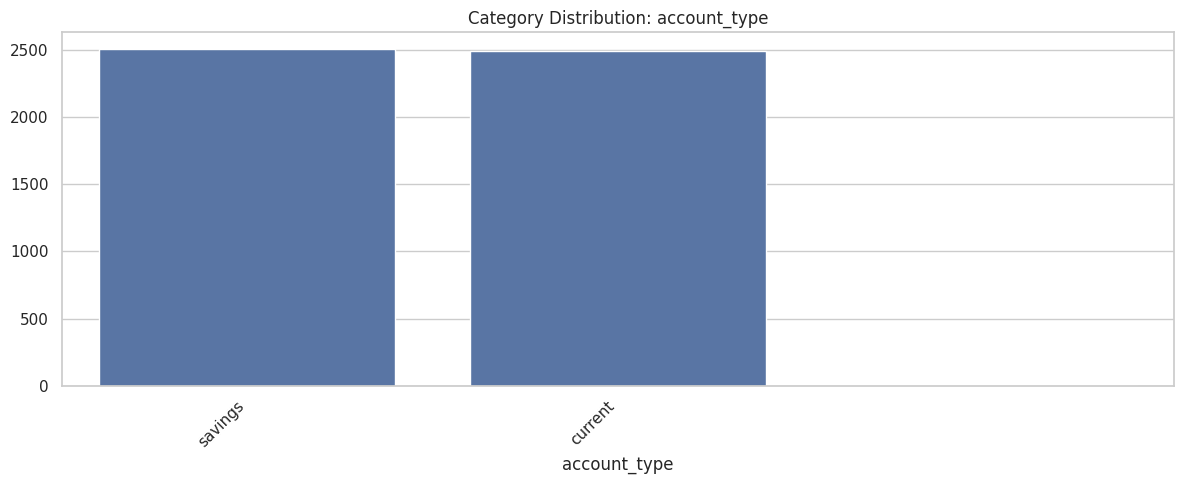

--------------------------------------------------------------------------------

===== COLUMN: account_opening_date (datetime64[ns]) =====
Count: 5000, Missing: 3 (0.06%)
Min Date: 1995-01-03 00:00:00
Max Date: 2024-12-22 00:00:00
Range: 10946 days


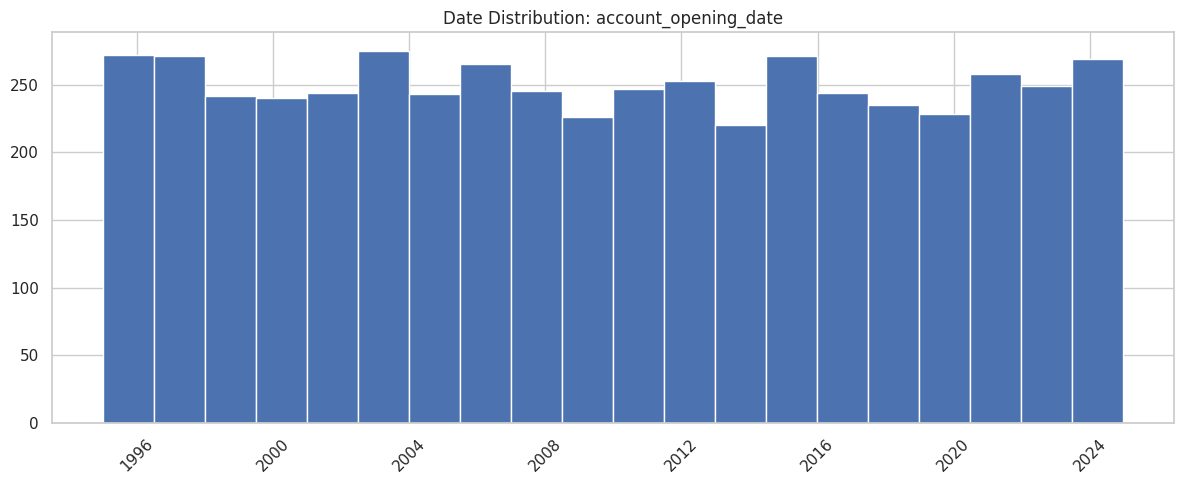

--------------------------------------------------------------------------------


In [115]:
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_accounts = OutlierDetector(cleaned_accounts_df)
outlier_results_accounts = outlier_detector_accounts.analyze_dataframe()
outlier_detector_accounts.display_outlier_analysis(outlier_results_accounts)

#### Plotting


--- PLOTTING EXAMPLES ---



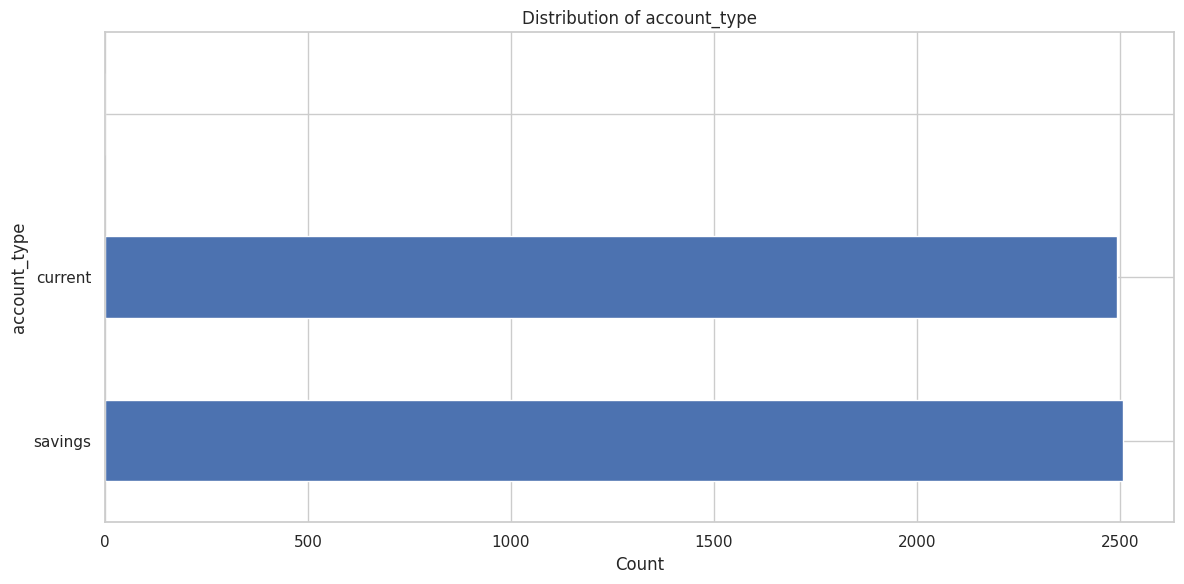

In [116]:
print("\n--- PLOTTING EXAMPLES ---\n")
plotter = Plotter(cleaned_accounts_df)

# Plot city distribution if available
plotter.plot_categorical_distribution('account_type', top_n=10)

### Customer Table




In [117]:
customers_df = execute_query("SELECT * FROM raw.customers")
customers_df.head()


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
0,1,Joshua,Heck,79,Male,Address_1,Fort Worth,490248463613,joshua.heck@aol.com,14.06.2017,43
1,2,Mark,Fleischmann,70,Female,Address_2,Louisville,490374533855,mark.fleischmann@posteo.de,28.10.2016,63
2,3,Joseph,Wilke,88,Female,Address_3,Philadelphia,490320325342,joseph.wilke@posteo.de,08.09.2004,82
3,4,Kevin,Seifert,62,Other,Address_4,Oklahoma City,490229477177,kevin.seifert@web.de,27.10.1995,41
4,5,Linda,Mann,18,Other,Address_5,Phoenix,490260430689,linda.mann@aol.com,14.06.2012,9



#### Check Data Quality

In [118]:


# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_customers = DataQualityAnalyzer(customers_df)
quality_analyzer_customers.show_samples_with_cleaning(n_samples=3)



--- DATA QUALITY ANALYSIS ---

DataFrame shape: (10000, 11)
Data types:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1253
  2. Original: 4685
  3. Original: 1732

firstname (object):
  1. Original: 'Sandra'
  2. Original: 'Jennifer'
  3. Original: 'Paul'

lastname (object):
  1. Original: 'Kersten'
  2. Original: 'Wahl'
  3. Original: 'Mahler'

Age (int32):
  1. Original: 53
  2. Original: 49
  3. Original: 78

Gender (object):
  1. Original: 'Male'
  2. Original: 'Female'
  3. Original: 'Other'

Address (object):
  1. Original: 'Address_1253'
  2. Original: 'Address_4685'
  3. Original: 'Address_1732'

City 

In [119]:
date_format_analysis = quality_analyzer_customers.analyze_date_formats()
quality_analyzer_customers.print_date_format_analysis(date_format_analysis)

Date Format Analysis

Column: creation_date
  Total non-null values: 10000
  Date formats detected:
    DD.MM.YYYY: 10000 (100.00%)


In [120]:
customer_email_analysis_results = quality_analyzer_customers.analyze_emails(
    email_column='Email'
)

quality_analyzer_customers.print_email_analysis(customer_email_analysis_results)


Email Validation Results
Total emails analyzed: 10000
Null/missing emails: 0
Valid emails: 8918 (89.18%)
Invalid emails: 1082
Unique domains found: 7

Top 10 Most Common Domains:
  gmx.net: 1342 emails
  posteo.de: 1326 emails
  aol.com: 1272 emails
  googlemail.com: 1268 emails
  outlook.com: 1262 emails
  web.de: 1228 emails
  yahoo.com: 1220 emails

Common Error Types:
  Username contains invalid characters: 1082 emails

Examples of Invalid Emails:
  Index 8: daniel.weiß@gmx.net - Username contains invalid characters
  Index 21: donna.könig@web.de - Username contains invalid characters
  Index 49: sandra.bär@posteo.de - Username contains invalid characters
  Index 53: timothy.rösler@outlook.com - Username contains invalid characters
  Index 76: susan.heß@googlemail.com - Username contains invalid characters
  Index 81: susan.schütze@outlook.com - Username contains invalid characters
  Index 124: daniel.köhn@posteo.de - Username contains invalid characters
  Index 129: michelle.dörr@


#### Clean Data

In [121]:

print("\n--- DATA CLEANING ---\n")
cleaner_customers = DataCleaner(customers_df)
cleaned_customers_df = cleaner_customers.clean_dataframe()


print(f"Before cleaning shape: {customers_df.shape}")
print(f"After cleaning shape: {cleaned_customers_df.shape}")
print("\nBefore cleaning dtypes:")
print(customers_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_customers_df.dtypes)



--- DATA CLEANING ---

Before cleaning shape: (10000, 11)
After cleaning shape: (10000, 11)

Before cleaning dtypes:
customer_id        int32
firstname         object
lastname          object
Age                int32
Gender            object
Address           object
City              object
Contact Number     int64
Email             object
creation_date     object
branch_id          int32
dtype: object

After cleaning dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object



#### ID Analysis

In [122]:

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_customers = IDAnalyzer(cleaned_customers_df)
id_analysis_customers = id_analyzer_customers.check_id_duplicates(["customer_id", "Address"])
id_analyzer_customers.display_duplicate_analysis(analysis_results=id_analysis_customers)

id_props_cust = id_analyzer_customers.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")


--- ID ANALYSIS ---

DataFrame Shape: (10000, 11)
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
DUPLICATES FOUND: 5000 distinct values are duplicated
Total records with duplicate values: 10000

Duplicate values (value: count):
  - 5000: 2 occurrences
  - 1: 2 occurrences
  - 2: 2 occurrences
  - 3: 2 occurrences
  - 4: 2 occurrences
  - 5: 2 occurrences
  - 6: 2 occurrences
  - 7: 2 occurrences
  - 4984: 2 occurrences
  - 4983: 2 occurrences
  - 4982: 2 occurrences
  - 4981: 2 occurrences
  - 4980: 2 occurrences
  - 4979: 2 occurrences
  - 4978: 2 occurrences
  - 4977: 2 occurrences
  - 4976: 2 occurrences
  - 4975: 2 occurrences
  - 4974: 2 occurrences
  - 4973: 2 occurrences
  - 4972: 2 occurrences
  - 4971: 2 occurrences
  - 4970: 2 occurrences
  - 4969: 2 occurrences
  - 40: 2 occurrences
  - 39: 2 occurrences
  - 38: 2 occurrences
  - 37: 2 occurrences
  - 36: 2 occurrences
  - 35: 2 occ

In [123]:
digits_count = id_analyzer_customers.count_digits_in_column('customer_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



Digit counts in Contact Number:
customer_id
4    8002
3    1800
2     180
1      18
Name: count, dtype: int64


In [124]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 10]


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
9,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30
5009,10,William,Wunderlich,56,Other,Address_10,Washington,49038012406,william.wunderlich@yahoo.com,1999-10-07,30


In [125]:
cleaned_customers_df.loc[lambda x: x['customer_id'] == 20]

,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
19,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61
5019,20,Amanda,Junge,70,Other,Address_20,Milwaukee,49087921618,amanda.junge@posteo.de,2024-10-08,61


In [126]:
# print shape before dropping duplicates
print(f"Before dropping duplicates shape: {cleaned_customers_df.shape}")
# dropping duplicates
cleaned_customers_df = cleaned_customers_df.drop_duplicates(subset=['customer_id'], keep='last')
print(f"After dropping duplicates shape: {cleaned_customers_df.shape}")
print("\nAfter dropping duplicates dtypes:")
print(cleaned_customers_df.dtypes)
# Check if duplicates are removed
duplicates_after = cleaned_customers_df.duplicated(subset=['customer_id']).sum()
print(f"Duplicates after removal: {duplicates_after}")

Before dropping duplicates shape: (10000, 11)
After dropping duplicates shape: (5000, 11)

After dropping duplicates dtypes:
customer_id                int32
firstname                 object
lastname                  object
Age                        int32
Gender                    object
Address                   object
City                      object
Contact Number             int64
Email                     object
creation_date     datetime64[ns]
branch_id                  int32
dtype: object
Duplicates after removal: 0



#### Descriptive Statistics

In [127]:
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_customers = DescriptiveStats(cleaned_customers_df)
stats_customers = stats_analyzer_customers.analyze_dataframe()
stats_analyzer_customers.print_descriptive_stats(stats_customers)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00%)
Most Common: Timothy (124 occurrences, 2.48%)

Top 5 values:
  - Timothy: 124 occurrences
  - Ronald: 123 occurrences
  - Andrew: 117 occurrences
  - Charles: 115 occurrences
  - Betty: 114 occurrences
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92%)
Most Common: Schütt (13 occurrences, 0.26%)

T


#### Outlier Detection


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 11)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: firstname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 50 (1.00% of total)
Most Common: Timothy (124 occurrences, 2.48%)
Rare Categories: 25
25 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: lastname (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 996 (19.92% of total)
Most Common: Schütt (13 occurrences, 0.26%)
Rare Categories: 996
996 rare categories found
-----------------------------------------------------------

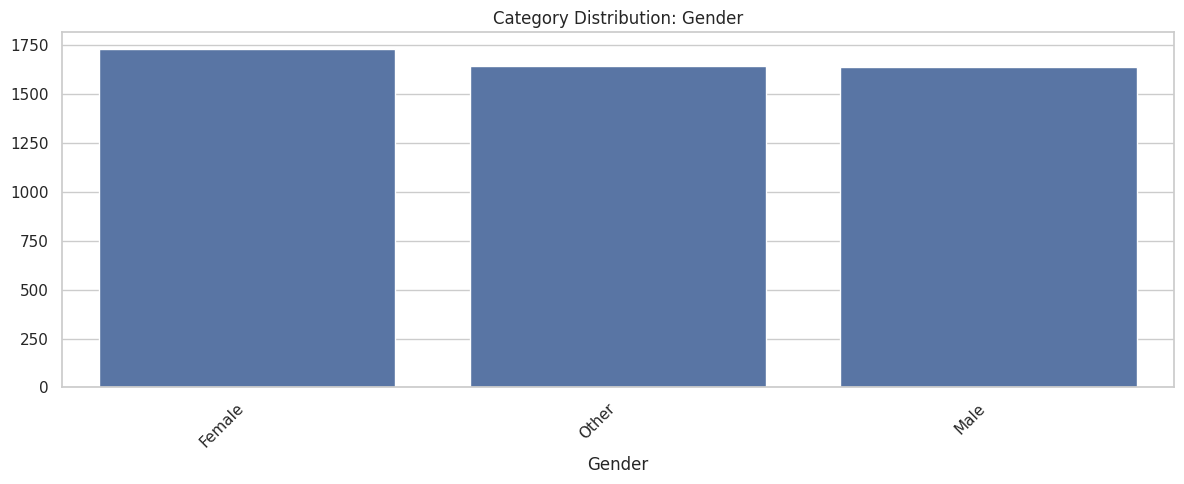

--------------------------------------------------------------------------------

===== COLUMN: Address (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00% of total)
Most Common: Address_5000 (1 occurrences, 0.02%)
Rare Categories: 5000
5000 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: City (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 40 (0.80% of total)
Most Common: San Jose (163 occurrences, 3.26%)
Rare Categories: 20
20 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: Contact Number (int64) =====
Count: 5000, Missing: 0 (0.00%)
Min: 49037065, Max: 490999756607
Mean: 408144494563.85, Median: 490440032285.50, Std: 173667729681.33
Skewness: -1.64
Outliers (IQR method): 920 (18.40%)
Outliers (Z-score method): 0 (0.00%)
920 outliers found


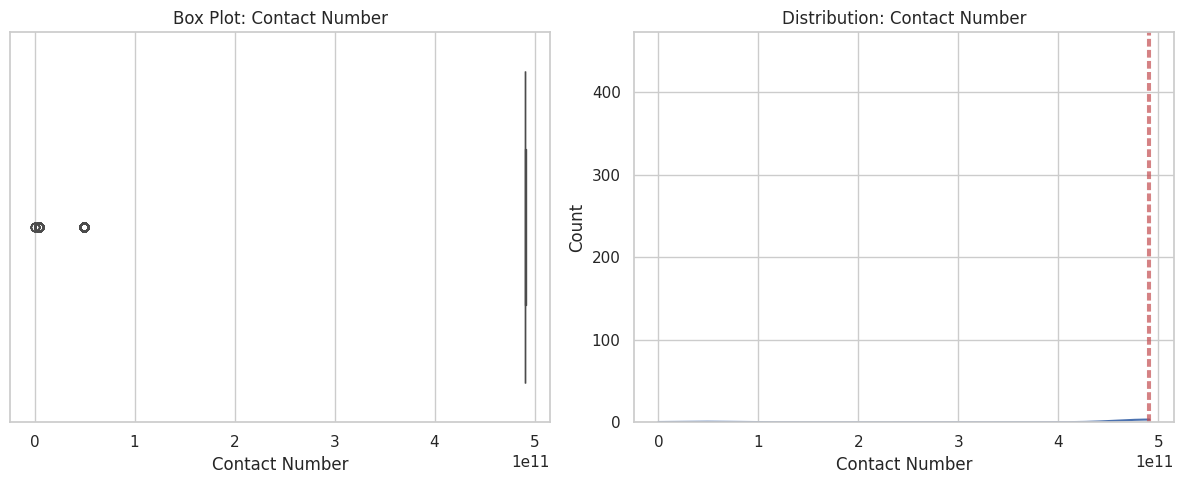

--------------------------------------------------------------------------------

===== COLUMN: Email (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 4944 (98.88% of total)
Most Common: kenneth.rudolf@gmx.net (2 occurrences, 0.04%)
Rare Categories: 4944
4944 rare categories found
--------------------------------------------------------------------------------

===== COLUMN: creation_date (datetime64[ns]) =====
Count: 5000, Missing: 0 (0.00%)
Min Date: 1995-01-02 00:00:00
Max Date: 2024-12-28 00:00:00
Range: 10953 days


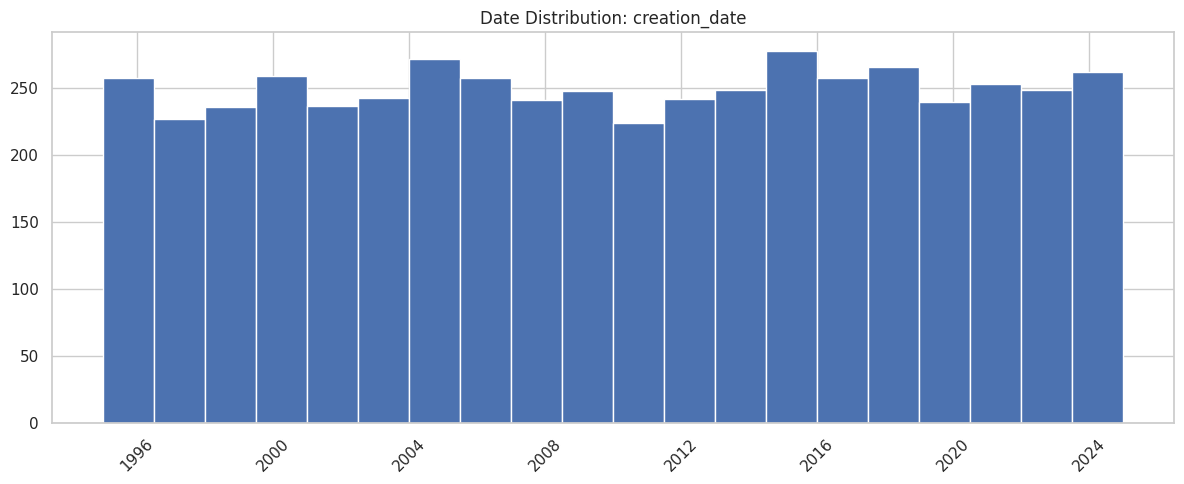

--------------------------------------------------------------------------------

===== COLUMN: branch_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 99
Mean: 50.59, Median: 50.00, Std: 28.50
Skewness: -0.01
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------


In [128]:
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_customers = OutlierDetector(cleaned_customers_df)
outlier_results_customers = outlier_detector_customers.analyze_dataframe()
outlier_detector_customers.display_outlier_analysis(outlier_results_customers)


In [129]:
cleaned_customers_df.columns


Index(['customer_id', 'firstname', 'lastname', 'Age', 'Gender', 'Address',
       'City', 'Contact Number', 'Email', 'creation_date', 'branch_id'],
      dtype='object')

In [130]:
cleaned_customers_df.loc[lambda x: x['Email'] == "kenneth.rudolf@gmx.net"]


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
5787,788,Kenneth,Rudolf,52,Male,Address_788,Austin,490794413570,kenneth.rudolf@gmx.net,2010-07-06,21
9693,4694,Kenneth,Rudolf,48,Male,Address_4694,Austin,490927229298,kenneth.rudolf@gmx.net,2005-01-06,74


In [131]:
# Get all rows where the email appears more than once
duplicate_emails_df = cleaned_customers_df[cleaned_customers_df["Email"].duplicated(keep=False)]

# Sort by email to group duplicates together
duplicate_emails_df = duplicate_emails_df.sort_values("Email")

duplicate_emails_df


,customer_id,firstname,lastname,Age,Gender,Address,City,Contact Number,Email,creation_date,branch_id
6570,1571,Andrew,Heil,28,Other,Address_1571,Nashville,490529759730,andrew.heil@gmx.net,1996-08-13,21
7637,2638,Andrew,Heil,59,Other,Address_2638,Oklahoma City,490242559267,andrew.heil@gmx.net,2005-12-12,63
5353,354,Andrew,Schröter,19,Other,Address_354,Portland,490603644749,andrew.schröter@posteo.de,2008-12-26,10
8089,3090,Andrew,Schröter,64,Male,Address_3090,Columbus,490104731279,andrew.schröter@posteo.de,2001-04-03,10
5358,359,Ashley,Ebner,77,Female,Address_359,Dallas,490541267315,ashley.ebner@gmx.net,2024-10-21,55
...,...,...,...,...,...,...,...,...,...,...,...
6308,1309,Susan,Ziegler,45,Other,Address_1309,Tucson,490186389068,susan.ziegler@outlook.com,2009-12-10,54
6089,1090,William,Dietrich,32,Female,Address_1090,Tucson,490783883261,william.dietrich@posteo.de,2023-08-26,71
6866,1867,William,Dietrich,25,Other,Address_1867,Las Vegas,490391660417,william.dietrich@posteo.de,1996-06-16,35
8591,3592,William,Reiter,71,Female,Address_3592,Nashville,490971569670,william.reiter@gmx.net,2007-01-27,42



#### Plotting


--- PLOTTING EXAMPLES ---



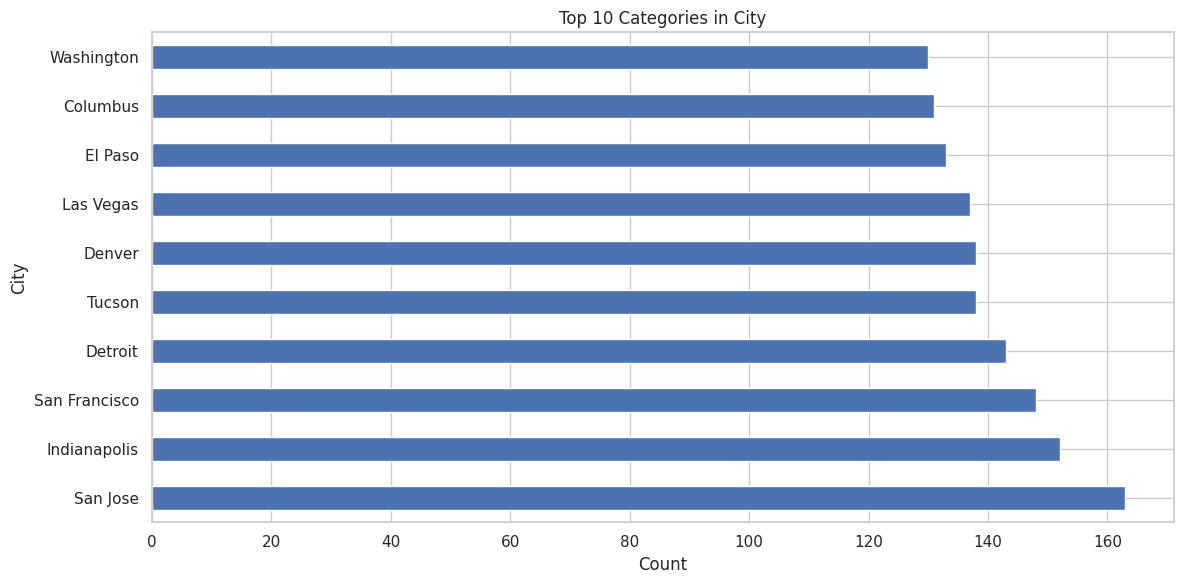

In [132]:
print("\n--- PLOTTING EXAMPLES ---\n")
plotter_customers = Plotter(cleaned_customers_df)

# Plot city distribution if available
plotter_customers.plot_categorical_distribution('City', top_n=10)

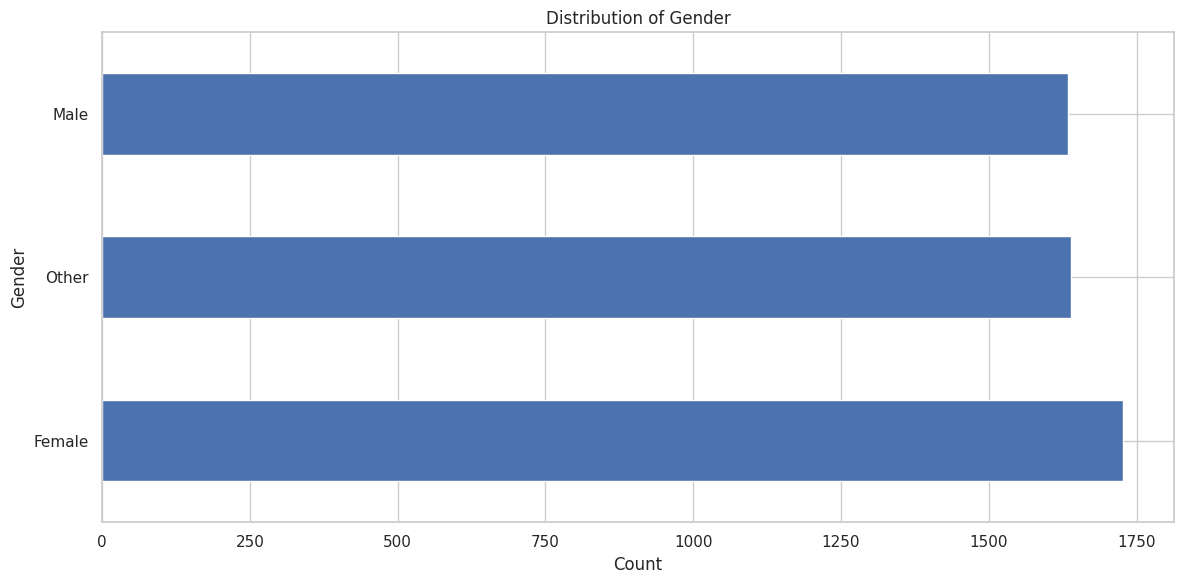

In [133]:
plotter_customers.plot_categorical_distribution('Gender', top_n=10)

In [134]:
cleaned_customers_df.groupby(["Address", "City"])["Address"].agg("count").describe()


count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: Address, dtype: float64

### Loans Table




In [135]:
loans_df = execute_query("SELECT * FROM raw.loans")
loans_df.head()



,customer_id,loan_id,loan_amount,loant_type,interest_rate,loan_term,approval_rejection_date,loan_status
0,1,1,"32200,06",mortgage,"0,0119",36,05.11.2021,rejected
1,2,2,"47743,52",auto,"0,0297",36,7/30/2020,approved
2,3,3,"47981,31",auto,"0,0267",24,1/17/2021,closed
3,4,4,"4482,8",personal,"0,0019",48,2/15/2022,approved
4,5,5,"1092,33",mortgage,"0,0115",12,7/31/2020,approved


#### Check Data Quality

In [136]:
# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_loans = DataQualityAnalyzer(loans_df)
quality_analyzer_loans.show_samples_with_cleaning(n_samples=3)


--- DATA QUALITY ANALYSIS ---

DataFrame shape: (5000, 8)
Data types:
customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
customer_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

loan_id (int32):
  1. Original: 1502
  2. Original: 2587
  3. Original: 2654

loan_amount (object):
  1. Original: '29149,52'
     Cleaned numeric: 29149.52
  2. Original: '48965,54'
     Cleaned numeric: 48965.54
  3. Original: '12395,31'
     Cleaned numeric: 12395.31

loant_type (object):
  1. Original: 'mortgage'
  2. Original: 'auto'
  3. Original: 'personal'

interest_rate (object):
  1. Original: '0,0176'
     Cleaned numeric: 0.0176
  2. Original

In [137]:
date_format_analysis = quality_analyzer_loans.analyze_date_formats()
quality_analyzer_loans.print_date_format_analysis(date_format_analysis)


Date Format Analysis

Column: approval_rejection_date
  Total non-null values: 5000
  Date formats detected:
    DD/MM/YYYY or MM/DD/YYYY: 3048 (60.96%)
    DD.MM.YYYY: 1952 (39.04%)


#### Clean Data

In [138]:

print("\n--- DATA CLEANING ---\n")
cleaner_loans = DataCleaner(loans_df)
cleaned_loans_df = cleaner_loans.clean_dataframe()

cleaned_loans_df = cleaned_loans_df.rename(columns={"loant_type": "loan_type"})


print(f"Before cleaning shape: {loans_df.shape}")
print(f"After cleaning shape: {cleaned_loans_df.shape}")
print("\nBefore cleaning dtypes:")
print(loans_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_loans_df.dtypes)



--- DATA CLEANING ---

Before cleaning shape: (5000, 8)
After cleaning shape: (5000, 8)

Before cleaning dtypes:
customer_id                 int32
loan_id                     int32
loan_amount                object
loant_type                 object
interest_rate              object
loan_term                   int32
approval_rejection_date    object
loan_status                object
dtype: object

After cleaning dtypes:
customer_id                         int32
loan_id                             int32
loan_amount                       float64
loan_type                          object
interest_rate                     float64
loan_term                           int32
approval_rejection_date    datetime64[ns]
loan_status                        object
dtype: object



#### ID Analysis

In [139]:

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_loans = IDAnalyzer(cleaned_loans_df)
id_analysis_loans = id_analyzer_loans.check_id_duplicates(["loan_id", "customer_id"])
id_analyzer_loans.display_duplicate_analysis(analysis_results=id_analysis_loans)

id_props_cust = id_analyzer_loans.check_id_properties('customer_id')
print("\nCustomer ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")

id_props_loan = id_analyzer_loans.check_id_properties('loan_id')
print("\nLoan ID Properties:")
print(f"Is unique: {id_props_cust['is_unique']}")
print(f"Is monotonic: {id_props_cust['is_monotonic']}")
digits_count = id_analyzer_loans.count_digits_in_column('customer_id')



--- ID ANALYSIS ---

DataFrame Shape: (5000, 8)
--------------------------------------------------------------------------------

===== COLUMN: loan_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COLUMN: customer_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COMPOSITE KEY ANALYSIS =====
Columns analyzed as composite key: loan_id, customer_id
No duplicates found. These columns together form a unique composite key.
--------------------------------------------------------------------------------

Customer ID Properties:
Is unique: True
Is monotonic: True

Loan ID Properties:
Is unique: True
Is monotonic: True



#### Descriptive Statistics

In [140]:
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_loans = DescriptiveStats(cleaned_loans_df)
stats_loans = stats_analyzer_loans.analyze_dataframe()
stats_analyzer_loans.print_descriptive_stats(stats_loans)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (5000, 8)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: loan_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Quartiles: Q1=1250.75, Q2=2500.50, Q3=3750.25
--------------------------------------------------------------------------------

===== COLUMN: loan_amount (float64) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 5000 (100.00%)
Min: 1006.37, Max: 49993.49
Mean: 25501.04, Median: 25909.71, Std: 14039.73
Skewness: -0.02
Quartiles: Q1=13315.31, Q2

#### Outlier Detection


--- OUTLIER DETECTION ---

DataFrame Shape: (5000, 8)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: customer_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: loan_id (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2500.50, Median: 2500.50, Std: 1443.52
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: loan_amount (float64) =====
Count: 5000, Missing: 0 (0.00%)
Min: 1006.37, Max: 49993.49
Mean: 25501.04, Median: 25909.71, Std: 14039.73
Skewness: -0.02
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
---

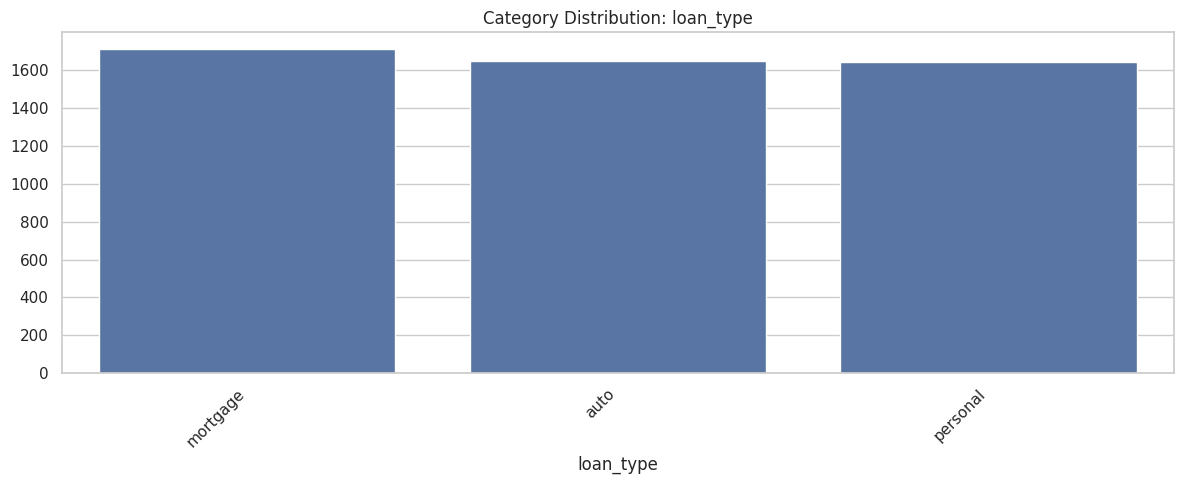

--------------------------------------------------------------------------------

===== COLUMN: interest_rate (float64) =====
Count: 5000, Missing: 0 (0.00%)
Min: 0.0, Max: 0.06
Mean: 0.03, Median: 0.03, Std: 0.02
Skewness: -0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: loan_term (int32) =====
Count: 5000, Missing: 0 (0.00%)
Min: 12, Max: 60
Mean: 36.52, Median: 36.00, Std: 16.92
Skewness: -0.04
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: approval_rejection_date (datetime64[ns]) =====
Count: 5000, Missing: 0 (0.00%)
Min Date: 2020-01-02 00:00:00
Max Date: 2022-12-31 00:00:00
Range: 1094 days


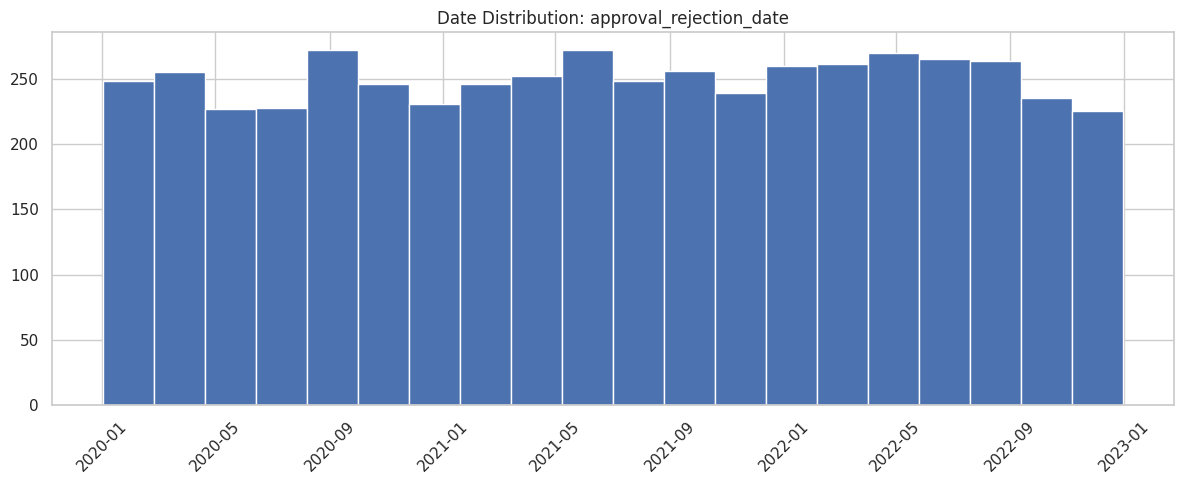

--------------------------------------------------------------------------------

===== COLUMN: loan_status (object) =====
Count: 5000, Missing: 0 (0.00%)
Unique Values: 3 (0.06% of total)
Most Common: approved (1710 occurrences, 34.20%)
Rare Categories: 2
Rare category values:
  - closed: 1660 occurrences
  - rejected: 1630 occurrences


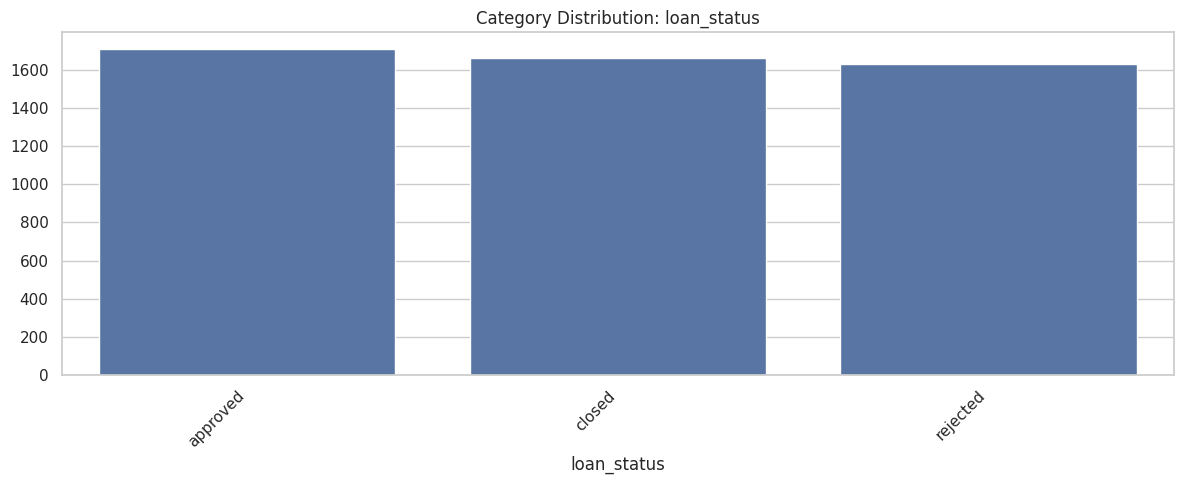

--------------------------------------------------------------------------------


In [141]:
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_loans = OutlierDetector(cleaned_loans_df)
outlier_results_loans = outlier_detector_loans.analyze_dataframe()
outlier_detector_loans.display_outlier_analysis(outlier_results_loans)

In [142]:
cleaned_loans_df.columns


Index(['customer_id', 'loan_id', 'loan_amount', 'loan_type', 'interest_rate',
       'loan_term', 'approval_rejection_date', 'loan_status'],
      dtype='object')


#### Plotting


--- PLOTTING EXAMPLES ---



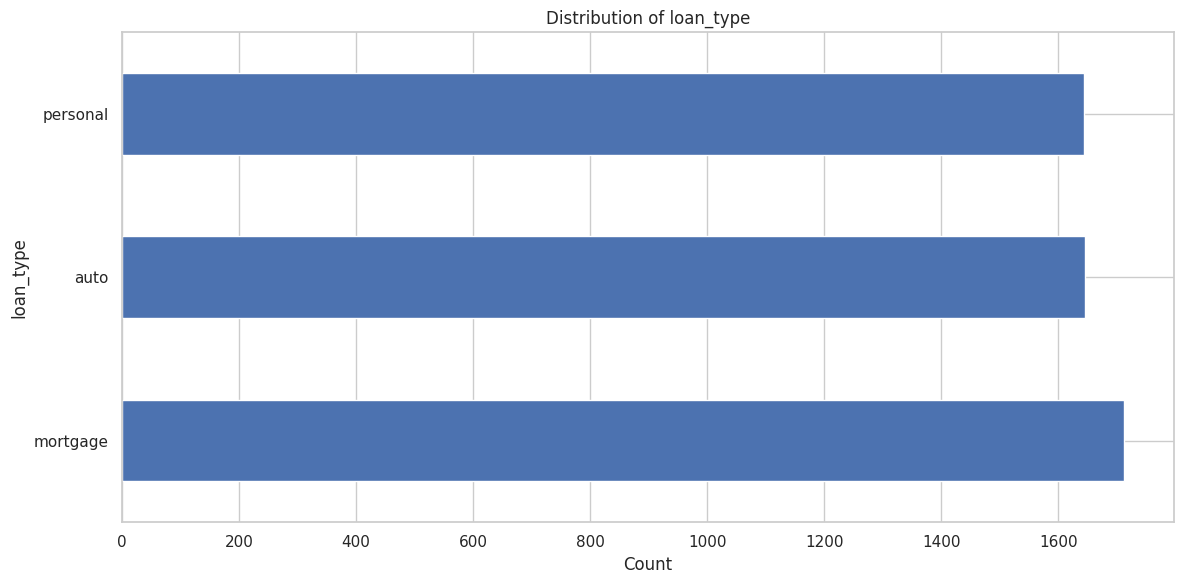

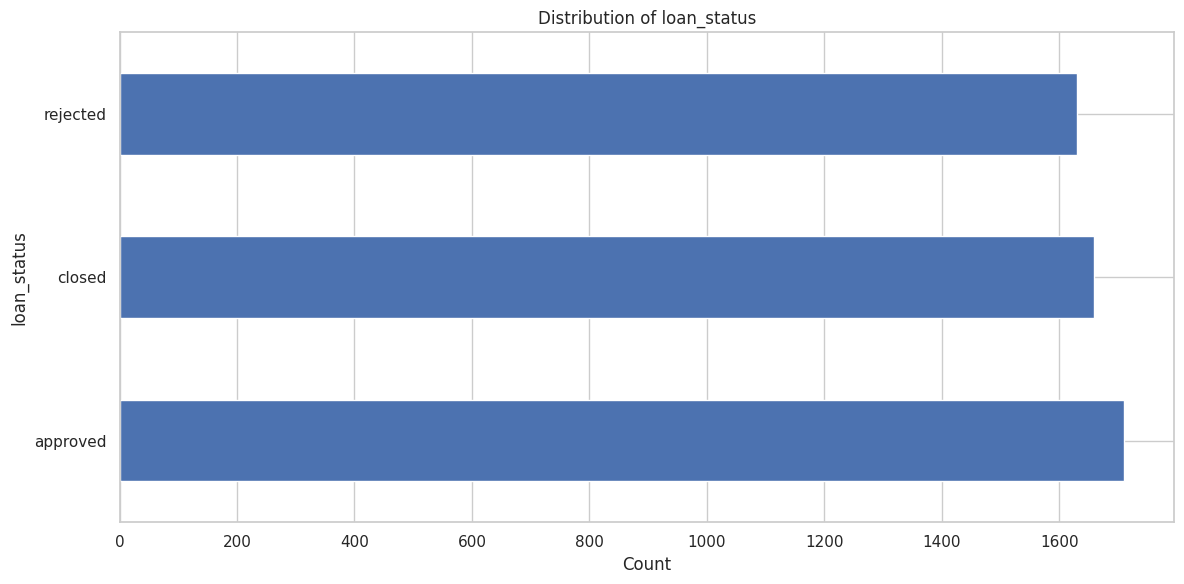

In [143]:
print("\n--- PLOTTING EXAMPLES ---\n")
plotter_loans = Plotter(cleaned_loans_df)

# Plot city distribution if available
plotter_loans.plot_categorical_distribution('loan_type', top_n=10)
plotter_loans.plot_categorical_distribution('loan_status', top_n=10)

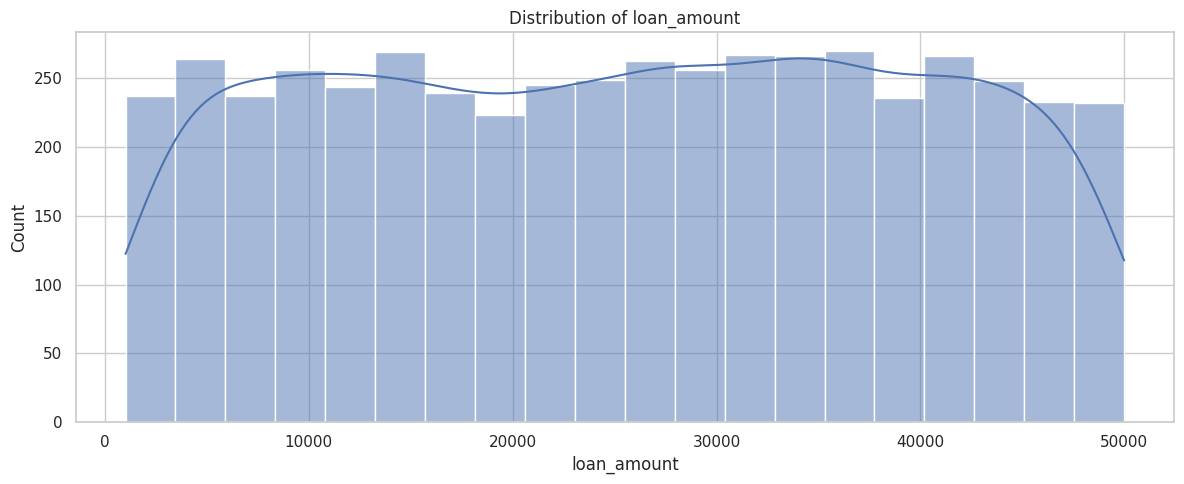

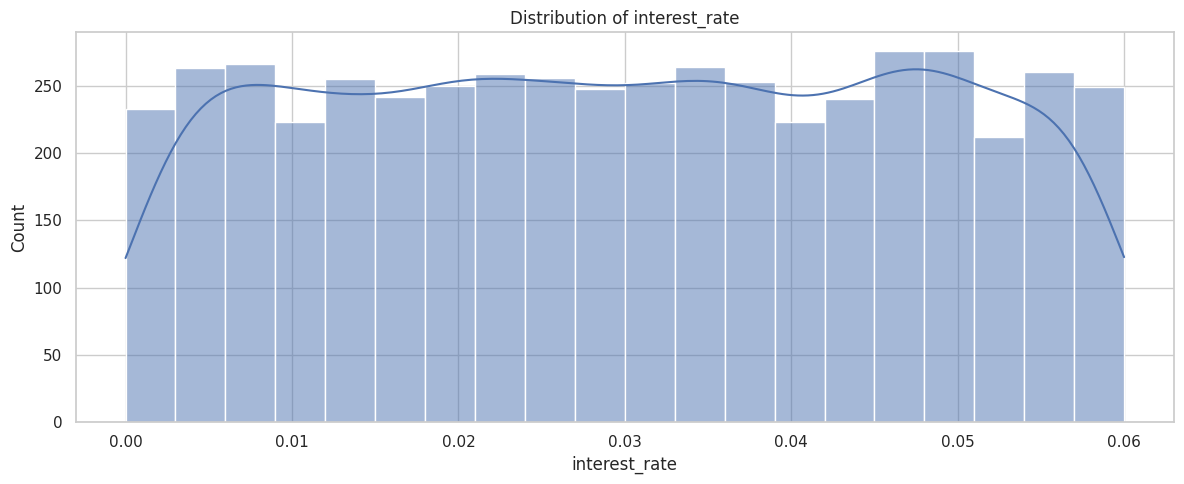

In [144]:
plotter_loans.plot_numeric_distribution('loan_amount', bins=20)
plotter_loans.plot_numeric_distribution('interest_rate', bins=20)


In [145]:
cleaned_loans_df.groupby(["loan_type"])["interest_rate"].agg(["count", "mean", "median", "std"])


,count,mean,median,std
loan_type,,,,
auto,1645,0.029972,0.0300,0.017403
mortgage,1712,0.029928,0.0299,0.017246
personal,1643,0.030168,0.0302,0.017148


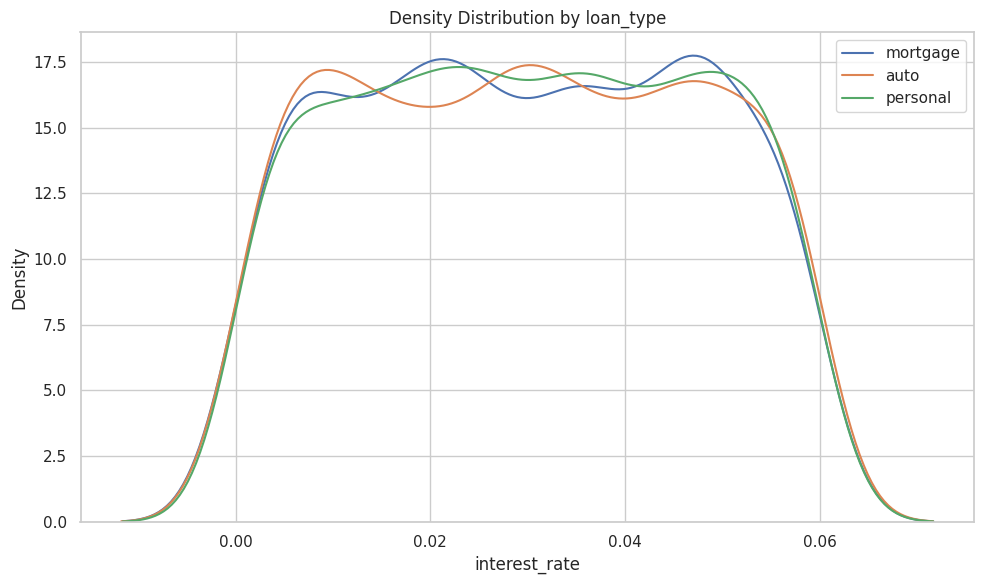

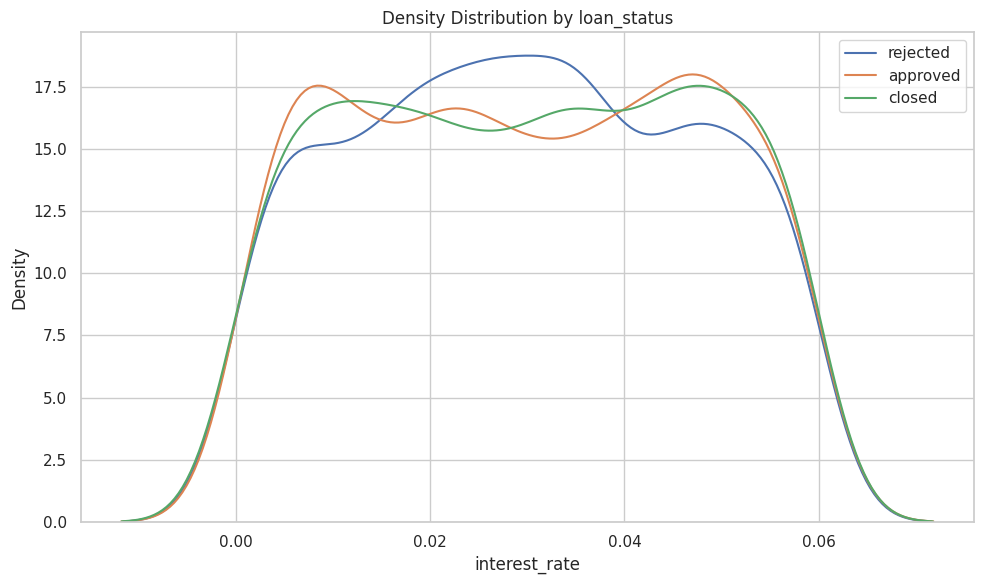

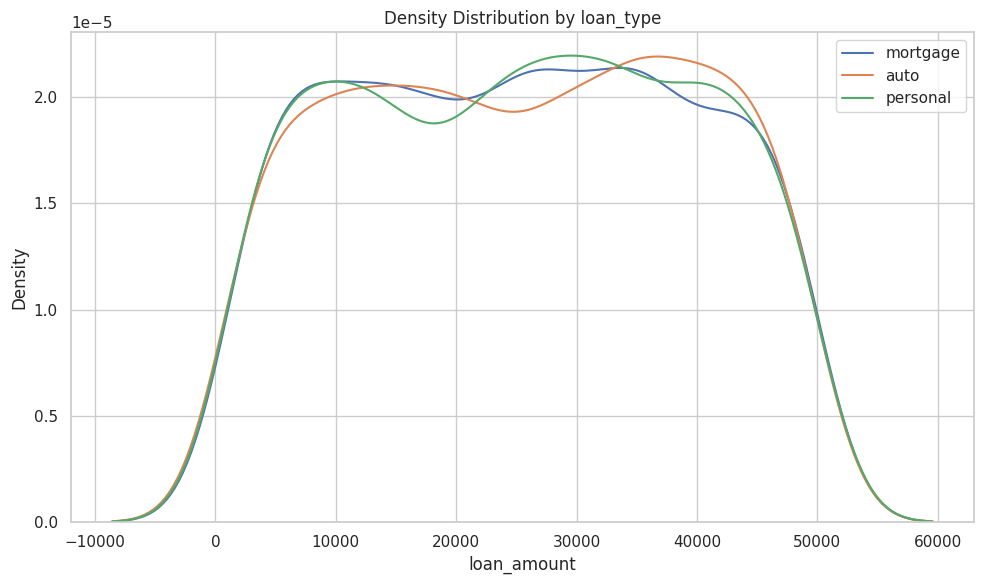

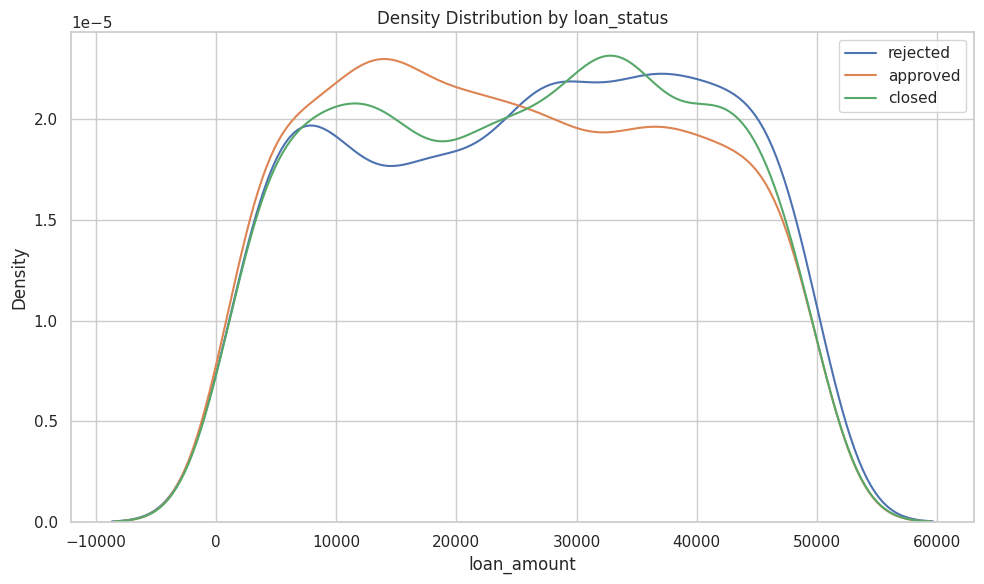

In [146]:
def plot_kde_by_cat(df : pd.DataFrame, cat_col : str, num_col : str):
    """
    Plot Kernel Density Estimate (KDE) by category.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        cat_col (str): Name of the categorical column.
        num_col (str): Name of the numerical column.
    """
    plt.figure(figsize=(10, 6))
    for category in df[cat_col].unique():
        subset = df[df[cat_col] == category][num_col]
        sns.kdeplot(subset, label=category)
    plt.legend()
    plt.title(f'Density Distribution by {cat_col}')
    plt.xlabel(num_col)
    plt.tight_layout()
    plt.show()

plot_kde_by_cat(cleaned_loans_df, 'loan_type', 'interest_rate')
plot_kde_by_cat(cleaned_loans_df, 'loan_status', 'interest_rate')
plot_kde_by_cat(cleaned_loans_df, 'loan_type', 'loan_amount')
plot_kde_by_cat(cleaned_loans_df, 'loan_status', 'loan_amount')

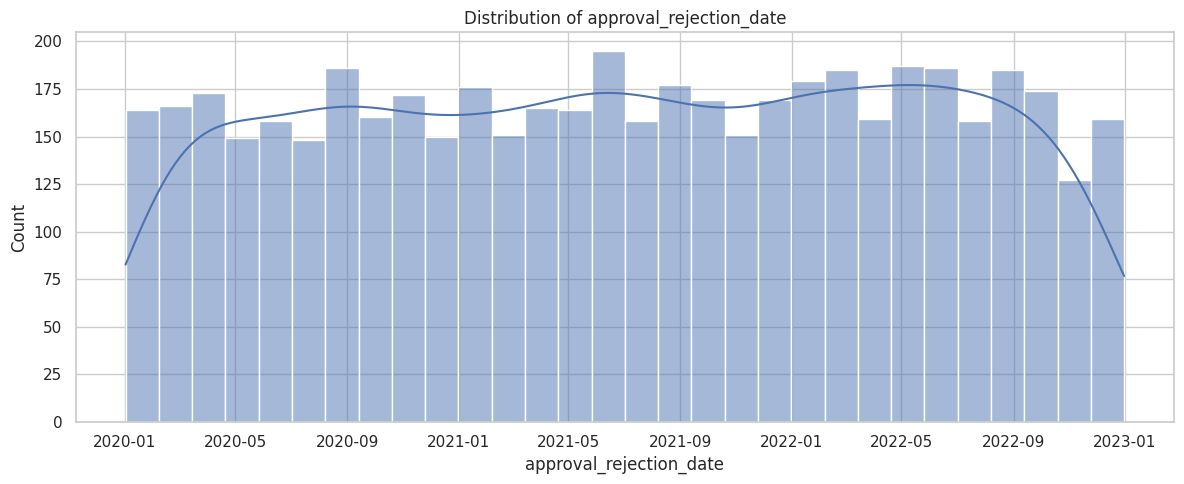

In [147]:
plotter_loans.plot_numeric_distribution('approval_rejection_date')


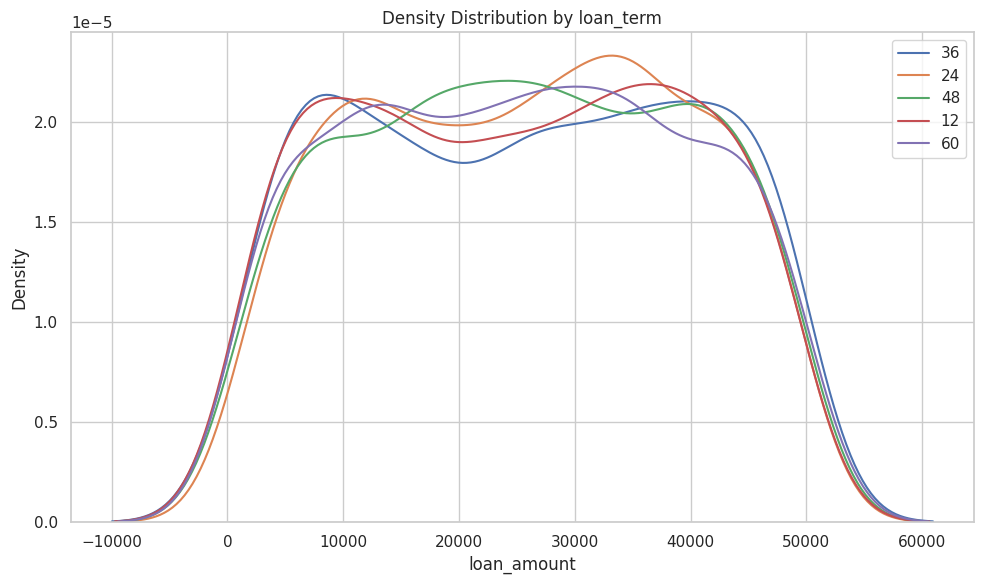

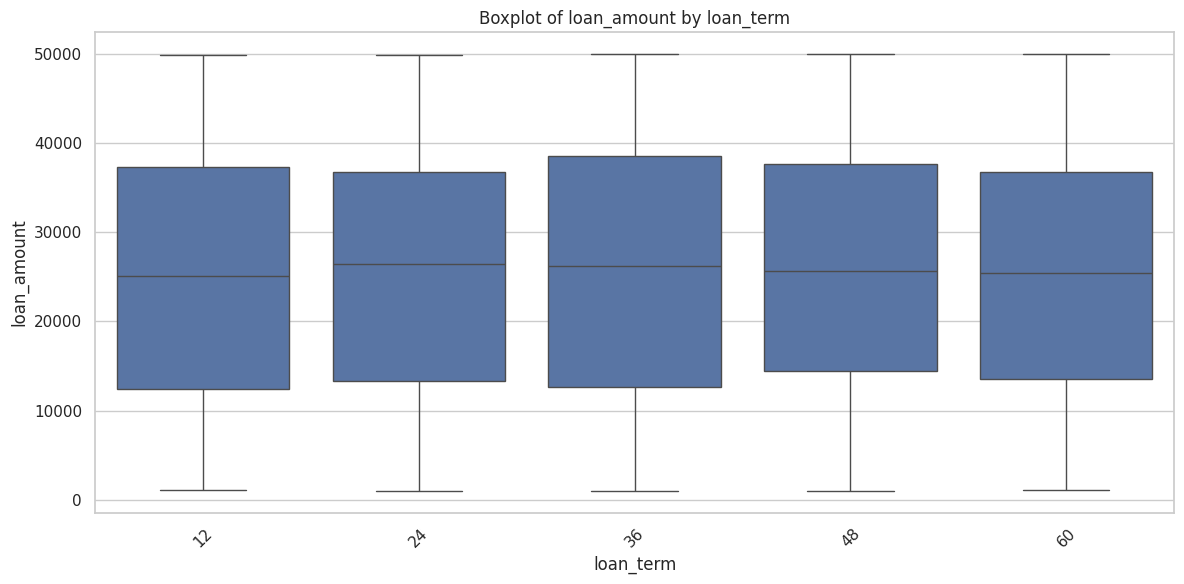

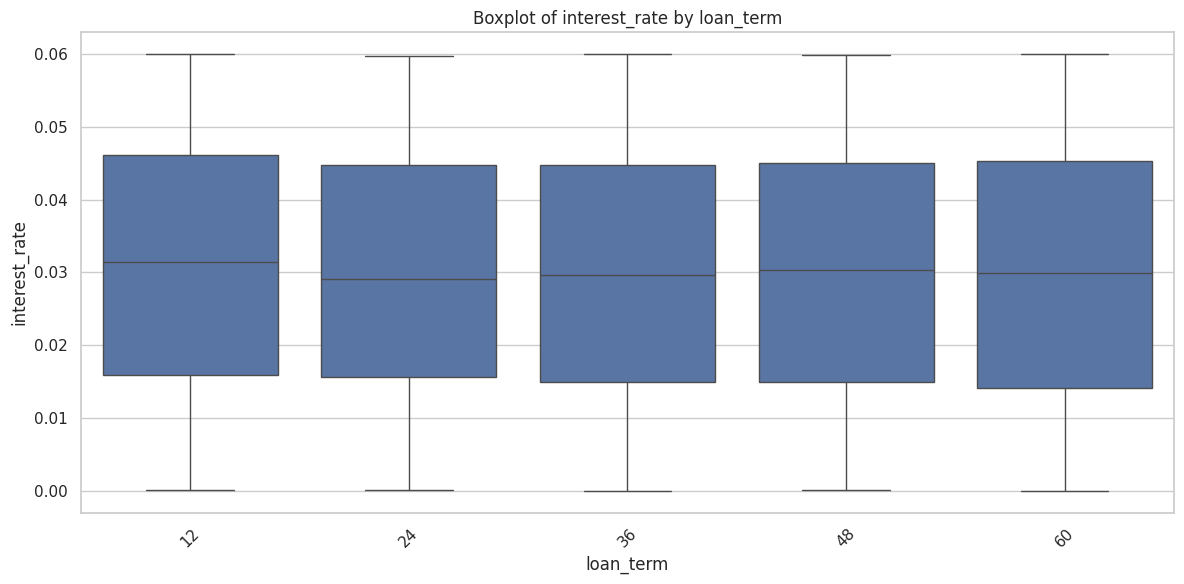

In [148]:
plot_kde_by_cat(cleaned_loans_df, 'loan_term', 'loan_amount')
plotter_loans.plot_boxplot("loan_amount", group_by="loan_term")
plotter_loans.plot_boxplot("interest_rate", group_by="loan_term")




### Transactions Table


In [149]:
transactions_df = execute_query("SELECT * FROM raw.transactions")
transactions_df.head()



,transaction_id,transaction_date,account_id,transaction_type,transaction_amount,transaction_currency
0,1000000,12.02.2025,3301,withdrawal,"1028,82",BGN
1,1000001,13.02.2025,82,withdrawal,"442,63",DKK
2,1000002,07.02.2025,1791,withdrawal,"5978,64",JPY
3,1000003,15.01.2025,1408,transfer,"8259,45",CHF
4,1000004,02.03.2025,4863,deposit,"7538,88",CZK



#### Check Data Quality

In [150]:


# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_transactions = DataQualityAnalyzer(transactions_df)
quality_analyzer_transactions.show_samples_with_cleaning(n_samples=3)




--- DATA QUALITY ANALYSIS ---

DataFrame shape: (56116, 6)
Data types:
transaction_id           int32
transaction_date        object
account_id               int32
transaction_type        object
transaction_amount      object
transaction_currency    object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
transaction_id (int32):
  1. Original: 1042734
  2. Original: 1055985
  3. Original: 1002298

transaction_date (object):
  1. Original: '17.02.2025'
     Cleaned date: 2025-02-17 (format: %d.%m.%Y)
  2. Original: '01.03.2025'
     Cleaned date: 2025-03-01 (format: %d.%m.%Y)
  3. Original: '22.01.2025'
     Cleaned date: 2025-01-22 (format: %d.%m.%Y)

account_id (int32):
  1. Original: 1227
  2. Original: 4560
  3. Original: 2595

transaction_type (object):
  1. Original: 'withdrawal'
  2. Original: 'transfer'
  3. Original: 'deposit'

transaction_amount (object):
  1. Original: '5947,59'
     Cleaned numeric: 5947.59


In [151]:
date_format_analysis = quality_analyzer_transactions.analyze_date_formats()
quality_analyzer_transactions.print_date_format_analysis(date_format_analysis)


Date Format Analysis

Column: transaction_date
  Total non-null values: 56116
  Date formats detected:
    DD.MM.YYYY: 56116 (100.00%)


In [152]:
transactions_df["transaction_id"].head()


0    1000000
1    1000001
2    1000002
3    1000003
4    1000004
Name: transaction_id, dtype: int32


#### Clean Data

In [153]:

print("\n--- DATA CLEANING ---\n")
cleaner_transactions = DataCleaner(transactions_df)
cleaned_transactions_df = cleaner_transactions.clean_dataframe()


print(f"Before cleaning shape: {transactions_df.shape}")
print(f"After cleaning shape: {cleaned_transactions_df.shape}")
print("\nBefore cleaning dtypes:")
print(transactions_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_transactions_df.dtypes)



--- DATA CLEANING ---

Before cleaning shape: (56116, 6)
After cleaning shape: (56116, 6)

Before cleaning dtypes:
transaction_id           int32
transaction_date        object
account_id               int32
transaction_type        object
transaction_amount      object
transaction_currency    object
dtype: object

After cleaning dtypes:
transaction_id                   int32
transaction_date        datetime64[ns]
account_id                       int32
transaction_type                object
transaction_amount             float64
transaction_currency            object
dtype: object



#### ID Analysis

In [154]:

# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_transactions = IDAnalyzer(cleaned_transactions_df)
id_analysis_transactions = id_analyzer_transactions.check_id_duplicates(["transaction_id", "account_id"])
id_analyzer_transactions.display_duplicate_analysis(analysis_results=id_analysis_transactions)

id_props_trans = id_analyzer_transactions.check_id_properties('transaction_id')
print("\Transaction ID Properties:")
print(f"Is unique: {id_props_trans['is_unique']}")
print(f"Is monotonic: {id_props_trans['is_monotonic']}")
digits_count = id_analyzer_transactions.count_digits_in_column('transaction_id')
print("\nDigit counts in Contact Number:")
print(digits_count.value_counts())



--- ID ANALYSIS ---

DataFrame Shape: (56116, 6)
--------------------------------------------------------------------------------

===== COLUMN: transaction_id =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------

===== COLUMN: account_id =====
Missing values: 0 (0.00%)
DUPLICATES FOUND: 5000 distinct values are duplicated
Total records with duplicate values: 56116

Duplicate values (value: count):
  - 4210: 24 occurrences
  - 4862: 24 occurrences
  - 70: 23 occurrences
  - 4261: 23 occurrences
  - 1205: 22 occurrences
  - 3712: 22 occurrences
  - 4282: 22 occurrences
  - 3878: 22 occurrences
  - 2575: 22 occurrences
  - 1335: 22 occurrences
  - 644: 22 occurrences
  - 1184: 22 occurrences
  - 1763: 21 occurrences
  - 4224: 21 occurrences
  - 3880: 21 occurrences
  - 2994: 21 occurrences
  - 979: 21 occurrences
  - 1854: 21 occurrences
  - 1939: 21 occurrences
  - 1224:


#### Descriptive Statistics

In [155]:
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_transactions = DescriptiveStats(cleaned_transactions_df)
stats_transactions = stats_analyzer_transactions.analyze_dataframe()
stats_analyzer_transactions.print_descriptive_stats(stats_transactions)



--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (56116, 6)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: transaction_id (int32) =====
Count: 56116, Missing: 0 (0.00%)
Unique Values: 56116 (100.00%)
Min: 1000000, Max: 1056115
Mean: 1028057.50, Median: 1028057.50, Std: 16199.44
Skewness: 0.00
Quartiles: Q1=1014028.75, Q2=1028057.50, Q3=1042086.25
--------------------------------------------------------------------------------

===== COLUMN: transaction_date (datetime64[ns]) =====
Count: 56116, Missing: 0 (0.00%)
Unique Values: 69 (0.12%)
Min Date: 2025-01-01 00:00:00
Max Date: 2025-03-10 00:00:00
Range: 68 days
--------------------------------------------------------------------------------

===== COLUMN: account_id (int32) =====
Count: 56116, Missing: 0 (0.00%)
Unique Values: 5000 (8.91%)
Min: 1, Max: 5000
Mean: 2506.57, Median: 2509.00, Std: 1440.63
Skewness: -0.00
Quartiles: Q1=1261.00, Q2=2509.00, Q3=3758.00



#### Outlier Detection


--- OUTLIER DETECTION ---

DataFrame Shape: (56116, 6)


Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: transaction_id (int32) =====
Count: 56116, Missing: 0 (0.00%)
Min: 1000000, Max: 1056115
Mean: 1028057.50, Median: 1028057.50, Std: 16199.44
Skewness: 0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: transaction_date (datetime64[ns]) =====
Count: 56116, Missing: 0 (0.00%)
Min Date: 2025-01-01 00:00:00
Max Date: 2025-03-10 00:00:00
Range: 68 days


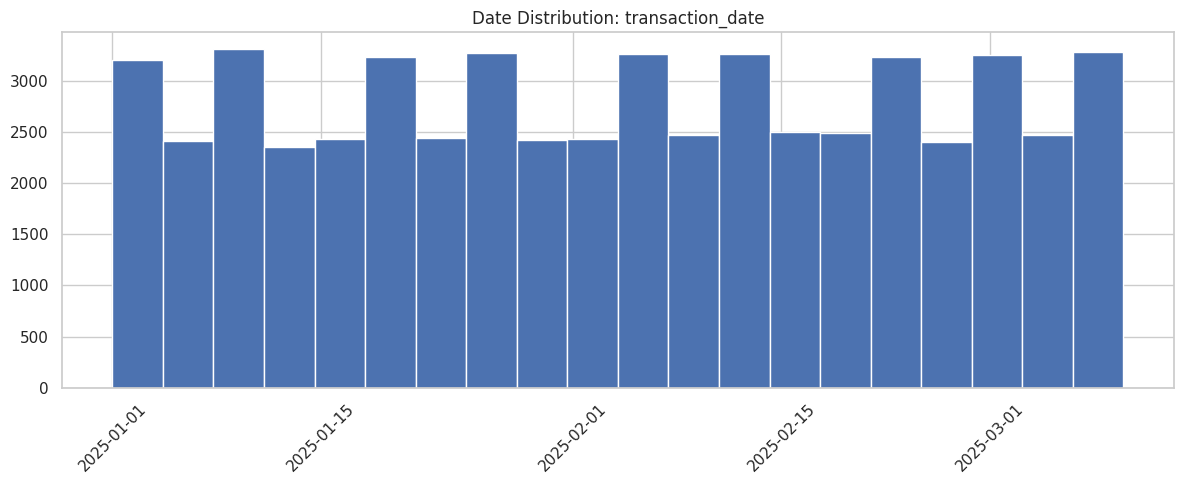

--------------------------------------------------------------------------------

===== COLUMN: account_id (int32) =====
Count: 56116, Missing: 0 (0.00%)
Min: 1, Max: 5000
Mean: 2506.57, Median: 2509.00, Std: 1440.63
Skewness: -0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: transaction_type (object) =====
Count: 56116, Missing: 0 (0.00%)
Unique Values: 3 (0.01% of total)
Most Common: transfer (18799 occurrences, 33.50%)
Rare Categories: 1
Rare category values:
  - withdrawal: 18608 occurrences


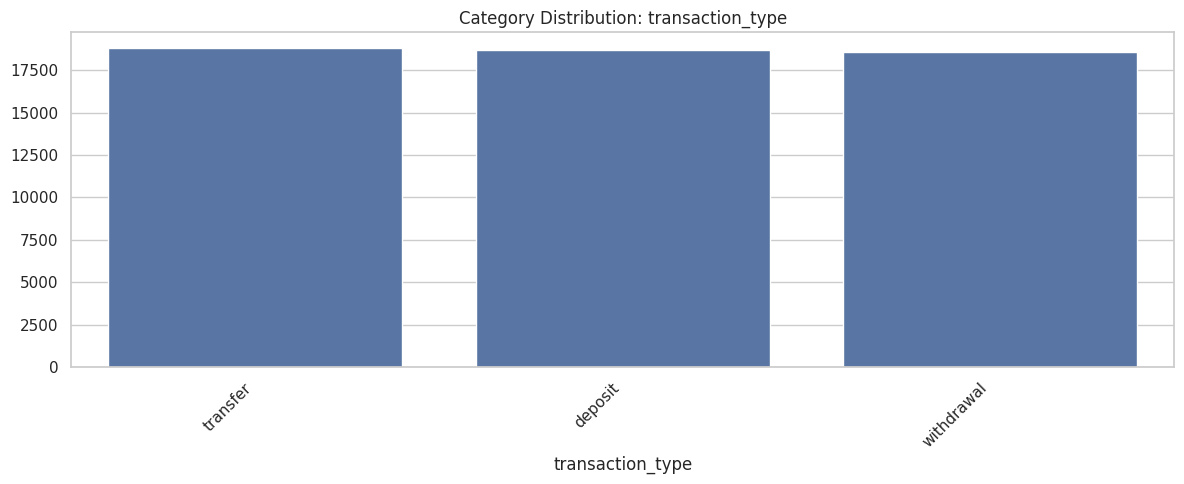

--------------------------------------------------------------------------------

===== COLUMN: transaction_amount (float64) =====
Count: 56116, Missing: 0 (0.00%)
Min: 0.05, Max: 9999.67
Mean: 5008.14, Median: 4998.45, Std: 2883.82
Skewness: -0.00
Outliers (IQR method): 0 (0.00%)
Outliers (Z-score method): 0 (0.00%)
--------------------------------------------------------------------------------

===== COLUMN: transaction_currency (object) =====
Count: 56116, Missing: 0 (0.00%)
Unique Values: 15 (0.03% of total)
Most Common: NOK (4050 occurrences, 7.22%)
Rare Categories: 1
Rare category values:
  - RON1: 1 occurrences


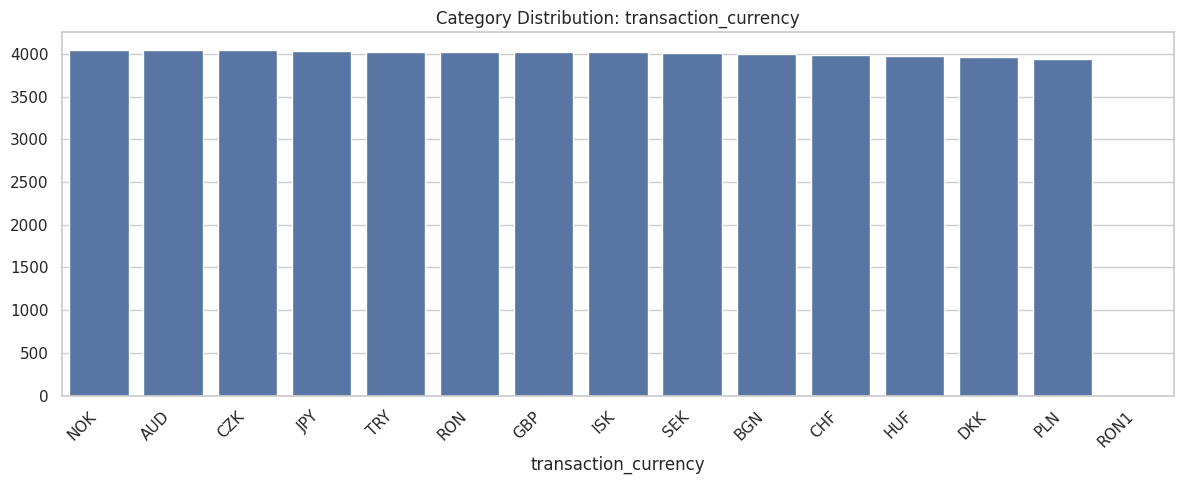

--------------------------------------------------------------------------------


In [156]:
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_transactions = OutlierDetector(cleaned_transactions_df)
outlier_results_transactions = outlier_detector_transactions.analyze_dataframe()
outlier_detector_transactions.display_outlier_analysis(outlier_results_transactions)


#### Plotting


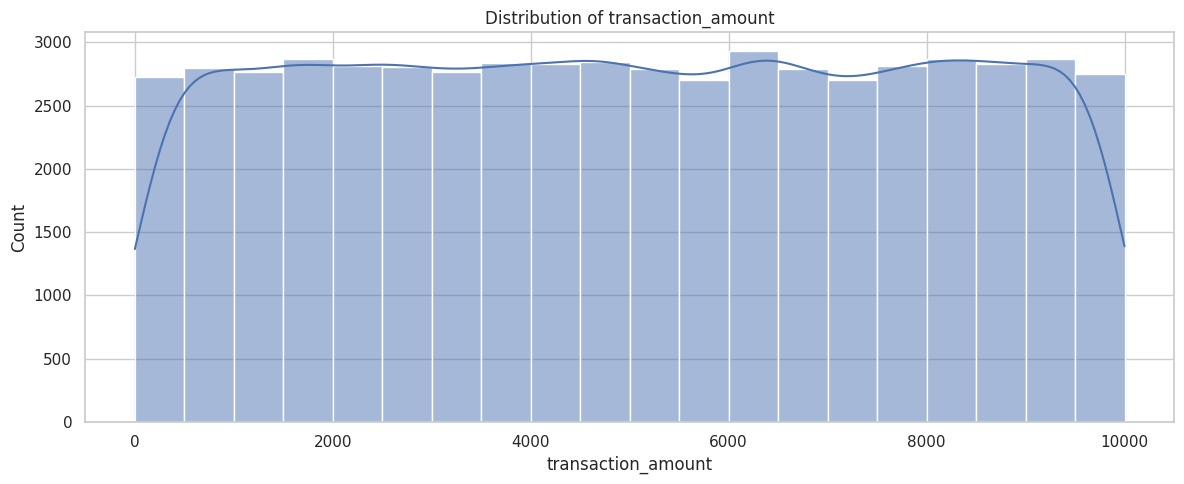

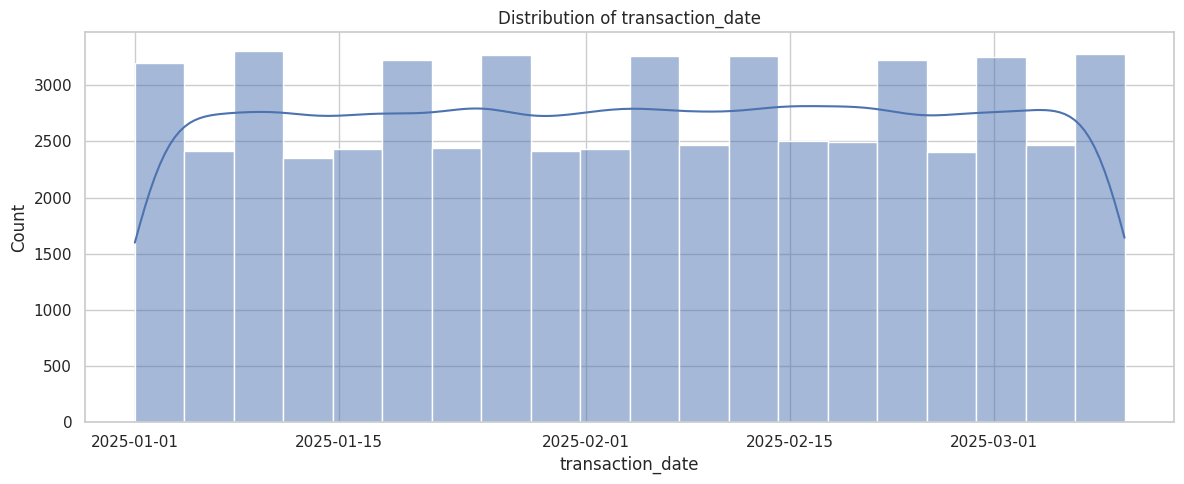

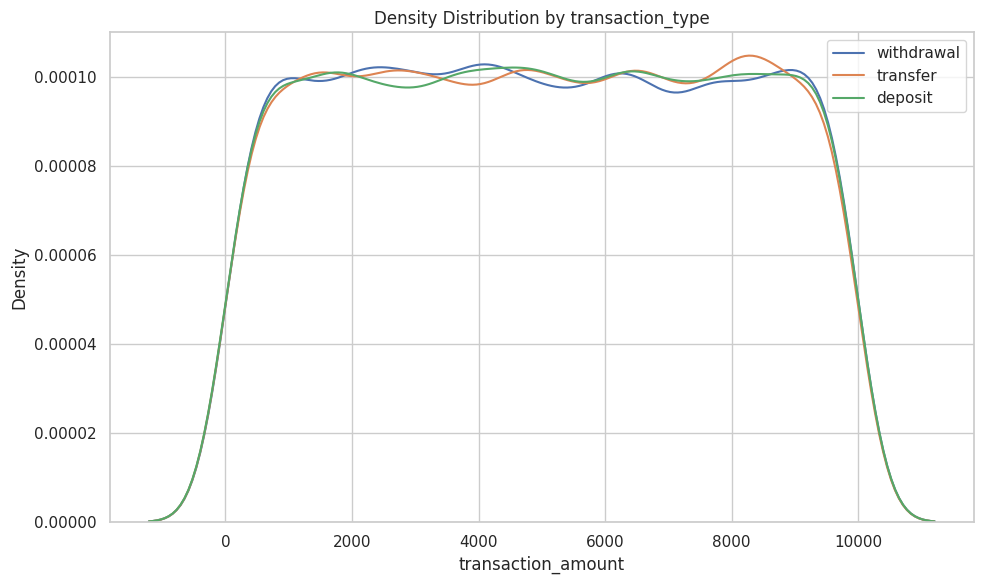

In [157]:
plotter_transactions = Plotter(cleaned_transactions_df)


plotter_transactions.plot_numeric_distribution('transaction_amount', bins=20)
plotter_transactions.plot_numeric_distribution('transaction_date', bins=20)


plot_kde_by_cat(cleaned_transactions_df, 'transaction_type', 'transaction_amount')

### Currencies Table 


In [158]:
DATA_PATH = REPO_DIR / 'data'
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data directory {DATA_PATH} does not exist. Please create it and add the required data files.")
# Load currencies data
currencies_path = DATA_PATH / 'currencies.csv'
if not currencies_path.exists():
    raise FileNotFoundError(f"Currencies data file {currencies_path} does not exist. Please create it and add the required data file.")
currencies_df = pd.read_csv(currencies_path, sep = ";")
currencies_df.head()


,currency,currency_iso_code
0,Russian ruble,RUB
1,Afghan afghani,AFN
2,Euro,EUR
3,Albanian lek,ALL
4,Algerian dinar,DZD


#### Check Data Quality

In [159]:
# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_currencies = DataQualityAnalyzer(currencies_df)
quality_analyzer_currencies.show_samples_with_cleaning(n_samples=3)


--- DATA QUALITY ANALYSIS ---

DataFrame shape: (169, 2)
Data types:
currency             object
currency_iso_code    object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
currency (object):
  1. Original: 'Solomon Islands dollar'
  2. Original: 'United States dollar'
  3. Original: 'Omani rial'

currency_iso_code (object):
  1. Original: 'SBD'
  2. Original: 'USDOL'
  3. Original: 'OMR'


Recommendations:
---------------



#### Clean Data

In [160]:
print("\n--- DATA CLEANING ---\n")
cleaner_currencies = DataCleaner(currencies_df)
cleaned_currencies_df = cleaner_currencies.clean_dataframe()


print(f"Before cleaning shape: {currencies_df.shape}")
print(f"After cleaning shape: {cleaned_currencies_df.shape}")
print("\nBefore cleaning dtypes:")
print(currencies_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_currencies_df.dtypes)




--- DATA CLEANING ---

Before cleaning shape: (169, 2)
After cleaning shape: (169, 2)

Before cleaning dtypes:
currency             object
currency_iso_code    object
dtype: object

After cleaning dtypes:
currency             object
currency_iso_code    object
dtype: object


#### ID Analysis

In [161]:
# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_currencies = IDAnalyzer(cleaned_currencies_df)
id_analysis_currencies = id_analyzer_currencies.check_id_duplicates(["currency_iso_code"])
id_analyzer_currencies.display_duplicate_analysis(analysis_results=id_analysis_currencies)



--- ID ANALYSIS ---

DataFrame Shape: (169, 2)
--------------------------------------------------------------------------------

===== COLUMN: currency_iso_code =====
Missing values: 0 (0.00%)
DUPLICATES FOUND: 2 distinct values are duplicated
Total records with duplicate values: 14

Duplicate values (value: count):
  - (none): 12 occurrences
  - USD: 2 occurrences

Duplicate records:
                       currency currency_iso_code
45          Cook Islands dollar            (none)
60                Faroese króna            (none)
68               Guernsey pound            (none)
79                   Manx pound            (none)
83                 Jersey pound            (none)
87           Kiribati dollar[E]            (none)
115              Niue dollar[E]            (none)
126  Pitcairn Islands dollar[E]            (none)
131              Sahrawi peseta            (none)
140         Somaliland shilling            (none)
152         Transnistrian ruble            (none)
156        

In [162]:
print("Before dropping duplicates and nones shape: ", cleaned_currencies_df.shape)
cleaned_currencies_df = cleaned_currencies_df.loc[lambda x: x['currency_iso_code'] != "(none)"].drop_duplicates(subset=['currency_iso_code'], keep='last')  
print("After dropping duplicates and nones shape: ", cleaned_currencies_df.shape)
print("\nAfter dropping duplicates and nones dtypes:")
print(cleaned_currencies_df.dtypes)
# Check if duplicates are removed
duplicates_after = cleaned_currencies_df.duplicated(subset=['currency_iso_code']).sum()
print(f"Duplicates after removal: {duplicates_after}")

Before dropping duplicates and nones shape:  (169, 2)
After dropping duplicates and nones shape:  (156, 2)

After dropping duplicates and nones dtypes:
currency             object
currency_iso_code    object
dtype: object
Duplicates after removal: 0


### FXRATES Table


In [163]:
fx_rates_df = execute_query("SELECT * FROM raw.fx_rates")
fx_rates_df.head()

,currency_iso_code,fx_rate,date,Column4
0,USD,1,01.03.2023,
1,JPY,"159,39",01.03.2023,
2,BGN,2,01.03.2023,
3,CZK,25,01.03.2023,
4,DKK,7,01.03.2023,


In [164]:
usd = fx_rates_df.loc[lambda x: x['currency_iso_code'].str.contains("USD", case = False)]

usd["currency_iso_code"].to_list()[0]

' USD'


#### Check Data Quality

In [165]:
# 1. Check Data Quality
print("\n--- DATA QUALITY ANALYSIS ---\n")
quality_analyzer_fx_rates = DataQualityAnalyzer(fx_rates_df)
quality_analyzer_fx_rates.show_samples_with_cleaning(n_samples=3)


--- DATA QUALITY ANALYSIS ---

DataFrame shape: (15, 4)
Data types:
currency_iso_code    object
fx_rate              object
date                 object
Column4              object
dtype: object

Sample values by column (with suggested cleaning):
--------------------------------------------------
currency_iso_code (object):
  1. Original: ' SEK'
     Cleaned whitespace: 'SEK'
  2. Original: ' ISK'
     Cleaned whitespace: 'ISK'
  3. Original: ' USD'
     Cleaned whitespace: 'USD'

fx_rate (object):
  1. Original: '11'
     Cleaned numeric: 11.0
  2. Original: '146,9'
     Cleaned numeric: 146.9
  3. Original: '1'
     Cleaned numeric: 1.0

date (object):
  1. Original: '01.03.2023'
     Cleaned date: 2023-03-01 (format: %d.%m.%Y)

Column4 (object):
  1. Original: ''


Recommendations:
---------------
Columns that should be converted from German number format: ['fx_rate']
Columns that should be converted from mixed date formats: ['date']

Date format distribution:
  date:
    DD.MM.YYYY


#### Clean Data

In [166]:

print("\n--- DATA CLEANING ---\n")
cleaner_fx_rates = DataCleaner(fx_rates_df)
cleaned_fx_rates_df = cleaner_fx_rates.clean_dataframe()

cleaned_fx_rates_df = cleaned_fx_rates_df.drop("Column4", axis = 1)

print(f"Before cleaning shape: {fx_rates_df.shape}")
print(f"After cleaning shape: {cleaned_fx_rates_df.shape}")
print("\nBefore cleaning dtypes:")
print(fx_rates_df.dtypes)
print("\nAfter cleaning dtypes:")
print(cleaned_fx_rates_df.dtypes)




--- DATA CLEANING ---

Before cleaning shape: (15, 4)
After cleaning shape: (15, 3)

Before cleaning dtypes:
currency_iso_code    object
fx_rate              object
date                 object
Column4              object
dtype: object

After cleaning dtypes:
currency_iso_code            object
fx_rate                     float64
date                 datetime64[ns]
dtype: object


In [172]:
cleaned_fx_rates_df.loc[lambda x: x['currency_iso_code'].isin(["USD", "AUD", "CAD", "EUR", "GBP", "NZD", "SGD", "CHF", "JPY"])]


,currency_iso_code,fx_rate,date
0,USD,1.00000,2023-03-01
1,JPY,159.39000,2023-03-01
5,GBP,0.83849,2023-03-01
10,CHF,0.95120,2023-03-01
14,AUD,2.00000,2023-03-01



#### ID Analysis

In [ ]:
# 3. ID Analysis
print("\n--- ID ANALYSIS ---\n")
id_analyzer_fx_rates = IDAnalyzer(cleaned_fx_rates_df)
id_analysis_fx_rates = id_analyzer_fx_rates.check_id_duplicates(["currency_iso_code"])
id_analyzer_fx_rates.display_duplicate_analysis(analysis_results=id_analysis_fx_rates)


--- ID ANALYSIS ---

DataFrame Shape: (15, 3)
--------------------------------------------------------------------------------

===== COLUMN: currency_iso_code =====
Missing values: 0 (0.00%)
No duplicates found. This column contains unique values.
--------------------------------------------------------------------------------



#### Descriptive Statistics

In [88]:
print("\n--- DESCRIPTIVE STATISTICS ---\n")
stats_analyzer_fx_rates = DescriptiveStats(cleaned_fx_rates_df)
stats_fx_rates = stats_analyzer_fx_rates.analyze_dataframe()
stats_analyzer_fx_rates.print_descriptive_stats(stats_fx_rates)




--- DESCRIPTIVE STATISTICS ---

DataFrame Shape: (15, 3)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: currency_iso_code (object) =====
Count: 15, Missing: 0 (0.00%)
Unique Values: 15 (100.00%)
Most Common: USD (1 occurrences, 6.67%)

Top 5 values:
  - USD: 1 occurrences
  - JPY: 1 occurrences
  - BGN: 1 occurrences
  - CZK: 1 occurrences
  - DKK: 1 occurrences
--------------------------------------------------------------------------------

===== COLUMN: fx_rate (float64) =====
Count: 15, Missing: 0 (0.00%)
Unique Values: 14 (93.33%)
Min: 0.83849, Max: 399.45
Mean: 54.44, Median: 7.00, Std: 108.46
Skewness: 2.70
Quartiles: Q1=2.00, Q2=7.00, Q3=32.50
--------------------------------------------------------------------------------

===== COLUMN: date (datetime64[ns]) =====
Count: 15, Missing: 0 (0.00%)
Unique Values: 1 (6.67%)
Min Date: 2023-03-01 00:00:00
Max Date: 2023-03-01 00:00:00
Range: 0 days
-------------


#### Outlier Detection


--- OUTLIER DETECTION ---

DataFrame Shape: (15, 3)
Total Missing Values: 0
--------------------------------------------------------------------------------

===== COLUMN: currency_iso_code (object) =====
Count: 15, Missing: 0 (0.00%)
Unique Values: 15 (100.00% of total)
Most Common: USD (1 occurrences, 6.67%)


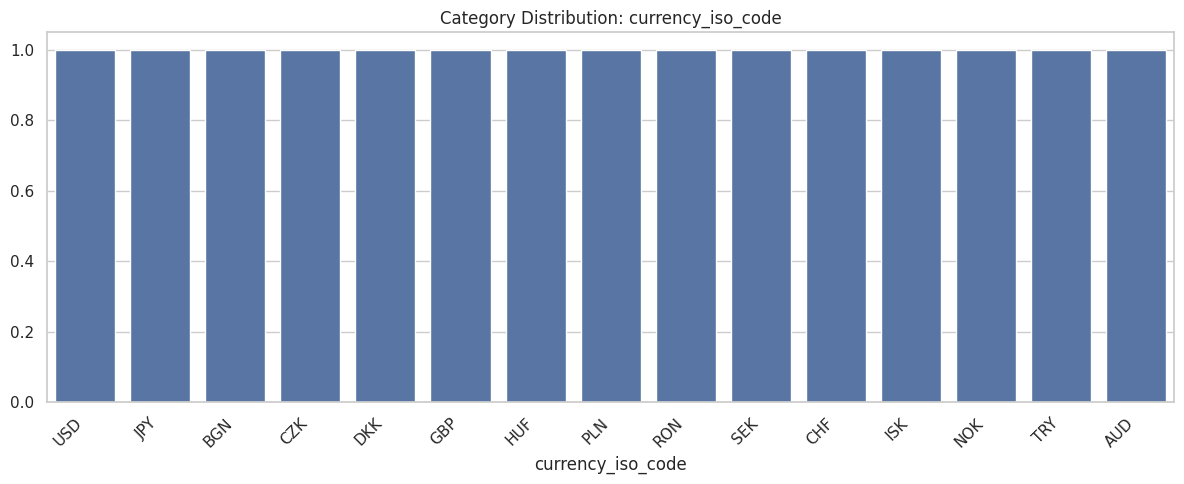

--------------------------------------------------------------------------------

===== COLUMN: fx_rate (float64) =====
Count: 15, Missing: 0 (0.00%)
Min: 0.83849, Max: 399.45
Mean: 54.44, Median: 7.00, Std: 108.46
Skewness: 2.70
Outliers (IQR method): 3 (20.00%)
Outliers (Z-score method): 1 (6.67%)
Outlier values:
  - 159.39: 1 occurrences
  - 399.45: 1 occurrences
  - 146.9: 1 occurrences


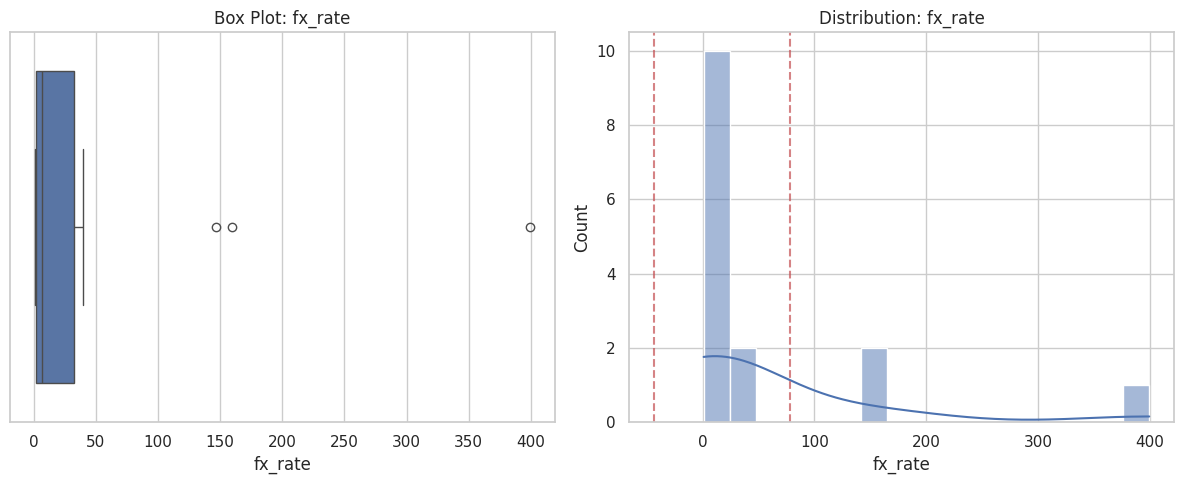

--------------------------------------------------------------------------------

===== COLUMN: date (datetime64[ns]) =====
Count: 15, Missing: 0 (0.00%)
Min Date: 2023-03-01 00:00:00
Max Date: 2023-03-01 00:00:00
Range: 0 days


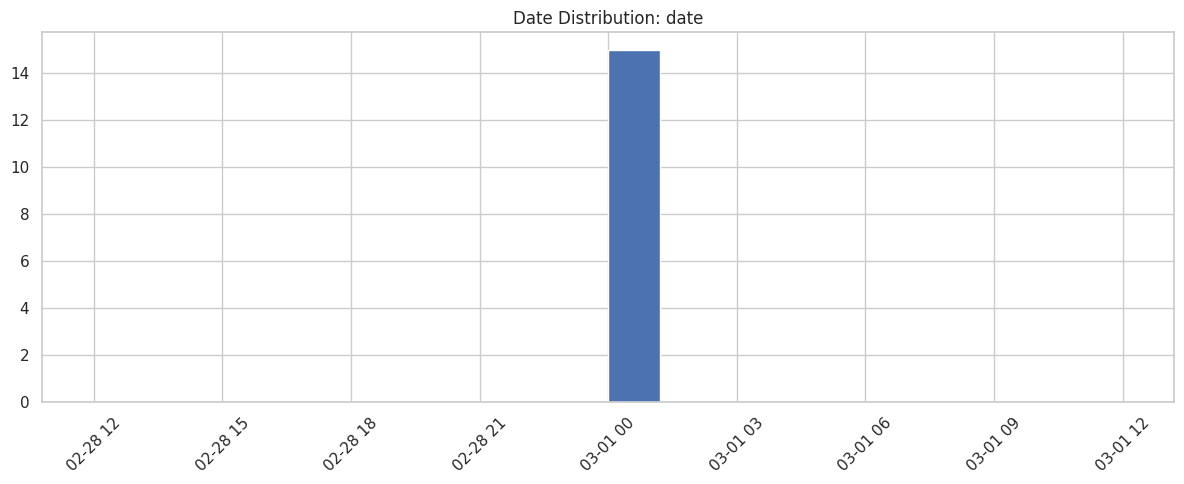

--------------------------------------------------------------------------------


In [89]:
print("\n--- OUTLIER DETECTION ---\n")
outlier_detector_fx_rates = OutlierDetector(cleaned_fx_rates_df)
outlier_results_fx_rates = outlier_detector_fx_rates.analyze_dataframe()
outlier_detector_fx_rates.display_outlier_analysis(outlier_results_fx_rates)


In [90]:
cleaned_fx_rates_df.sort_values(by = "fx_rate", ascending = False).head(10)


,currency_iso_code,fx_rate,date
6,HUF,399.45,2023-03-01
1,JPY,159.39,2023-03-01
11,ISK,146.90,2023-03-01
13,TRY,40.00,2023-03-01
3,CZK,25.00,2023-03-01
12,NOK,12.00,2023-03-01
9,SEK,11.00,2023-03-01
4,DKK,7.00,2023-03-01
8,RON,5.00,2023-03-01
7,PLN,4.00,2023-03-01


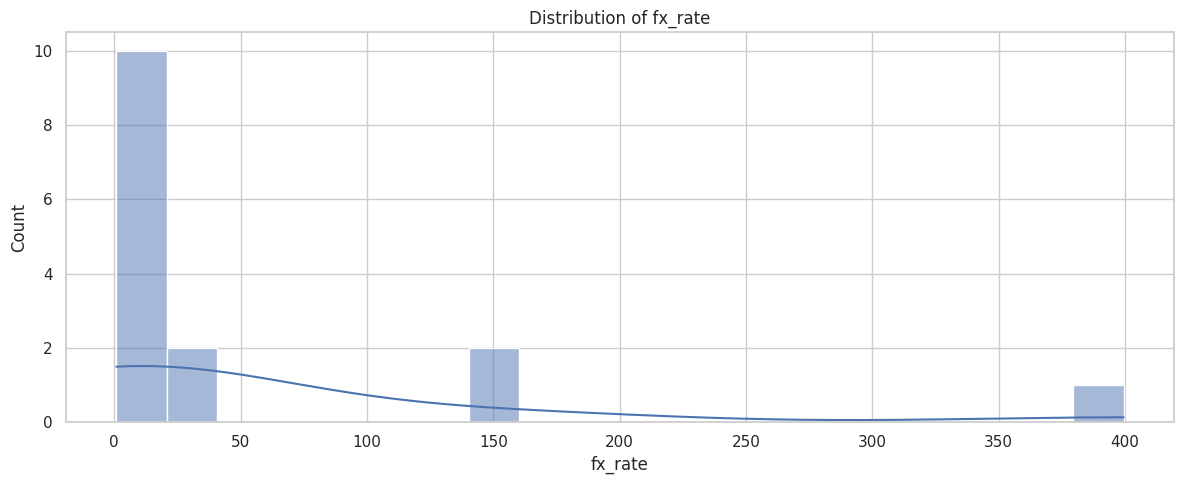

In [91]:
#### Plotting
plotter_fx_rates = Plotter(cleaned_fx_rates_df)
plotter_fx_rates.plot_numeric_distribution('fx_rate', bins=20)

In [173]:
conn.close()
